# XGBoost Train

In [1]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime

# 하이퍼파라미터 최적화
import optuna
from optuna.samplers import TPESampler


In [2]:
# =============================================================================
# 셀 2: 경로 설정 및 디렉토리 생성
# =============================================================================
# 경로 설정
data_dir = '/workspace/AI모델/projects/coin/data/xgboost_B_major'
output_dir = '/workspace/AI모델/projects/coin/models'

# 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# 설정값
N_FOLDS = 5     
N_TRIALS = 3   # 50 → 100으로 증가 (더 많은 시도)
RANDOM_STATE = 42

# GPU 최적화 설정
USE_GPU = True
GPU_DEVICE = 'cuda:0'
GPU_BATCH_SIZE = 10000
PARALLEL_JOBS = 1      # GPU 사용시에는 1 또는 2가 최적

# 메모리 모니터링 활성화
MEMORY_MONITORING = True

print(f"데이터 디렉토리: {data_dir}")
print(f"출력 디렉토리: {output_dir}")
print(f"K-Fold: {N_FOLDS}폴드, Optuna 시도: {N_TRIALS}회 (메모리 안전 모드)")
print(f"GPU 사용: {USE_GPU}")

# 시스템 메모리 확인
import psutil
total_ram = psutil.virtual_memory().total / (1024**3)
available_ram = psutil.virtual_memory().available / (1024**3)
print(f"시스템 RAM: {total_ram:.1f}GB (사용가능: {available_ram:.1f}GB)")

데이터 디렉토리: /workspace/AI모델/projects/coin/data/xgboost_B_major
출력 디렉토리: /workspace/AI모델/projects/coin/models
K-Fold: 5폴드, Optuna 시도: 3회 (메모리 안전 모드)
GPU 사용: True
시스템 RAM: 47.0GB (사용가능: 44.5GB)


# 주의! Data load
- 기존에 만든 병합된 학습용 데이터 /workspace/AI모델/projects/coin/data/xgboost_B
- 여기서의 라벨은 'Optimized_Label'임 이걸 -> Future_Label로 변환함 따라서 Future_Label이 진짜라벨

In [3]:
# =============================================================================
# 셀 3: 데이터 로드 및 전처리
# =============================================================================

def load_and_prepare_data(data_dir):
    """
    training_features.txt를 읽어서 기본 피처를 로드하고,
    추가 제외 항목을 적용하여 데이터 전처리
    """
    print("데이터 로드 및 전처리 시작...")
    
    # 1. training_features.txt 파일 읽기
    feature_file = os.path.join(data_dir, 'training_features.txt')
    
    if os.path.exists(feature_file):
        with open(feature_file, 'r') as f:
            base_features = [line.strip() for line in f.readlines() if line.strip()]
        print(f"training_features.txt에서 {len(base_features)}개 기본 피처 로드")
    else:
        print(f"⚠️ training_features.txt 파일이 없습니다: {feature_file}")
        base_features = None
    
    # 2. 데이터 로드
    train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
    val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
    
    print(f"\n데이터 로드 완료:")
    print(f"  훈련: {train_df.shape}")
    print(f"  검증: {val_df.shape}")
    print(f"  테스트: {test_df.shape}")
    
    # 3. 추가로 제외할 피쳐들 정의 (상관관계/VIF 분석 기반)
    additional_exclude = [
        # === 완전 중복 제거 (상관계수 1.0) ===
        # Williams_R 그룹 (Williams_R_14 = Williams_R = Stoch_K_14)
        'Williams_R', 'Williams_R_14', 'Stoch_K_14',
        
        # CCI 그룹 (CCI_20 = CCI)
        'CCI',
        
        # MFI 그룹 (MFI_14 = MFI)
        'MFI',
        
        # RSI normalized 그룹들 (원본과 1.0 상관)
        'RSI_4_normalized', 'RSI_5_normalized', 'RSI_6_normalized', 
        'RSI_7_normalized', 'RSI_12_normalized', 'RSI_14_normalized', 
        'RSI_20_normalized', 'RSI_21_normalized',
        
        # MACD 관련 완전 중복
        'MACD_10_20_signal_distance', 'MACD_15_26_signal_distance', 'MACD_5_27_signal_distance',
        
        # MA Cross 시그널들 (서로 완전 중복)
        'MA_Cross_3_25_Signal_distance', 'MA_Trend_Signal_ratio', 
        'MA_Trend_Signal_distance', 'EMA_Cross_5_20_Signal_ratio', 'EMA_Cross_6_24_Signal_ratio',
        
        # 볼린저밴드 완전 중복들
        'BB_Width_20', 'Volatility_20',
        
        # Pivot 관련 완전 중복
        'Support1', 'Resistance1',
        
        # Highest/Lowest 그룹들 (서로 0.99+ 상관)
        'Lowest_3', 'Highest_7', 'Lowest_7', 'Highest_8', 'Lowest_8',
        'Highest_10', 'Lowest_10', 'Highest_11', 'Lowest_11',
        'Highest_16', 'Lowest_16', 'Highest_17', 'Lowest_17',
        'Highest_28', 'Lowest_28',
        
        # === 높은 상관관계 (0.95+ 제거) ===
        'MACD_15_26', 'BB_Upper_20', 'BB_Lower_20', 'Stoch_D_14',
        'MA_7_ratio', 'MA_8_ratio', 'MA_25_ratio', 'MA_29_ratio', 
        'MA_60_ratio', 'MA_120_ratio', 'EMA_24_ratio', 'Close_return',
        
        # === VIF 무한대인 피쳐들 ===
        'RSI_Reverse_Signal', 'RSI_Extreme_Signal', 'RSI_20_75_Signal',
        'RSI_22_78_Signal', 'RSI_30_65_Signal', 'RSI_12_50_Signal',
        'MACD_Signal_Cross', 'RSI_Divergence', 'MACD_Cross',
        'MA_16_distance', 'MA_16_ratio',
        
        # === 기존 제거 항목들 ===
        'Volume_MA_20', 'MA_3', 'MA_5', 'MA_7', 'MA_10', 'MA_50',
        'EMA_26', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_relative_position',
        'MACD_Signal', 'MACD_Histogram', 'MACD_signal_distance',
        'RSI_normalized', '%D', 'Close_log_return', 'Open_log_return', 
        'Open_return', 'High_log_return', 'High_return', 'Low_log_return', 
        'Low_return', 'Return_2d', 'Return_3d', 'Return_7d', 'Return_10d', 
        'Return_14d', 'Return_21d', 'Return_42d', 'Return_63d',
        'MA_5_distance', 'MA_10_distance', 'MA_20_distance', 
        'MA_50_distance', 'MA_200_distance',
        'Future_1d', 'Future_3d', 'Future_7d', 'Future_14d', 
        'Future_30d', 'Future_90d', 'Future_180d', 'Future_365d',
        'True_Range', 'Volatility_20d', 'Stoch_overbought', 'Stoch_oversold',
        'SMI_Signal', 'quarter', 'dow_cos',
        'BB_upper_distance', 'BB_lower_distance', 'EMA_12_ratio', 'EMA_26_ratio',
    ]
    
    # 4. 최종 피쳐 결정
    if base_features is not None:
        # training_features.txt에서 추가 제외 항목을 빼기
        feature_columns = [f for f in base_features if f not in additional_exclude]
        print(f"\ntraining_features.txt 기반 피처: {len(base_features)}개")
        print(f"추가 제외 항목: {len(additional_exclude)}개")
    else:
        # training_features.txt가 없으면 전체 컬럼에서 제외
        exclude_all = [
            'Future_Label', 'Label', 'Label_Name', 'Optimized_Label', 'Optimized_Label_Name',
            'Symbol', 'Date', 'Symbol_encoded', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Composite_Signal_Avg', 'Buy_Signal_Count', 'Sell_Signal_Count',
            'Net_Signal_Score', 'Final_Composite_Signal', 'Price_Momentum_5',
            'Price_Momentum_10', 'Price_Momentum_20', 'Price_Position',
        ] + additional_exclude
        
        feature_columns = [col for col in train_df.columns if col not in exclude_all]
    
    # 5. 실제 존재하는 피쳐만 필터링
    feature_columns = [col for col in feature_columns if col in train_df.columns]
    
    # Future_Label 제거 (타겟이므로)
    if 'Future_Label' in feature_columns:
        feature_columns.remove('Future_Label')
    
    print(f"\n최종 피쳐 수: {len(feature_columns)}")
    
    # 6. Future_Label 확인
    if 'Future_Label' not in train_df.columns:
        raise ValueError("Future_Label 컬럼이 없습니다!")
    
    # 7. 훈련+검증 데이터 합치기
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    
    # 8. 피쳐와 타겟 분리
    X_train_val = train_val_df[feature_columns].fillna(0)
    y_train_val = train_val_df['Future_Label']
    
    X_test = test_df[feature_columns].fillna(0)
    y_test = test_df['Future_Label']
    
    # 9. 무한값 처리
    X_train_val = X_train_val.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)
    
    print(f"\n데이터 전처리 완료:")
    print(f"  X_train_val: {X_train_val.shape}")
    print(f"  X_test: {X_test.shape}")
    
    # 10. 클래스 분포 확인
    print(f"\n클래스 분포:")
    label_names = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
    
    for name, y in [("훈련+검증", y_train_val), ("테스트", y_test)]:
        counts = y.value_counts().sort_index()
        pcts = (counts / len(y) * 100).round(1)
        
        print(f"  {name}:")
        for label, count in counts.items():
            pct = pcts[label]
            label_name = label_names.get(int(label), f'Label_{int(label)}')
            print(f"    {int(label)} ({label_name}): {count:,}개 ({pct}%)")
    
    # 11. 클래스 균형도
    class_ratio = y_train_val.value_counts().min() / y_train_val.value_counts().max()
    print(f"\n클래스 균형도: {class_ratio:.3f} (1.0에 가까울수록 균형)")
    
    # 12. 데이터 검증
    print(f"\n데이터 검증:")
    print(f"  결측치 - X_train_val: {X_train_val.isnull().sum().sum()}")
    print(f"  결측치 - X_test: {X_test.isnull().sum().sum()}")
    print(f"  무한값 - X_train_val: {np.isinf(X_train_val.values).sum()}")
    print(f"  무한값 - X_test: {np.isinf(X_test.values).sum()}")
    
    return X_train_val, X_test, y_train_val, y_test, feature_columns


X_train_val, X_test, y_train_val, y_test, feature_columns = load_and_prepare_data(data_dir)

print(f"\n데이터 준비 완료!")
print(f"사용할 피쳐 수: {len(feature_columns)}")
print(f"샘플 피쳐들:")
for i, feat in enumerate(feature_columns[:15]):
    print(f"  {i+1:2d}. {feat}")
if len(feature_columns) > 15:
    print(f"  ... 외 {len(feature_columns)-15}개")

데이터 로드 및 전처리 시작...
training_features.txt에서 367개 기본 피처 로드

데이터 로드 완료:
  훈련: (33226, 386)
  검증: (7120, 386)
  테스트: (7120, 386)

training_features.txt 기반 피처: 367개
추가 제외 항목: 118개

최종 피쳐 수: 263

데이터 전처리 완료:
  X_train_val: (40346, 263)
  X_test: (7120, 263)

클래스 분포:
  훈련+검증:
    0 (Sell): 3,185개 (7.9%)
    1 (Hold): 33,965개 (84.2%)
    2 (Buy): 3,196개 (7.9%)
  테스트:
    0 (Sell): 619개 (8.7%)
    1 (Hold): 5,911개 (83.0%)
    2 (Buy): 590개 (8.3%)

클래스 균형도: 0.094 (1.0에 가까울수록 균형)

데이터 검증:
  결측치 - X_train_val: 0
  결측치 - X_test: 0
  무한값 - X_train_val: 0
  무한값 - X_test: 0

데이터 준비 완료!
사용할 피쳐 수: 263
샘플 피쳐들:
   1. MA_2
   2. MA_4
   3. MA_6
   4. MA_8
   5. MA_13
   6. MA_16
   7. MA_20
   8. MA_25
   9. MA_29
  10. MA_60
  11. MA_100
  12. MA_120
  13. MA_200
  14. EMA_3
  15. EMA_4
  ... 외 248개


# Data Check

In [4]:
import pandas as pd
pd.set_option("display.max_columns", None)   # 컬럼 생략 없이 전부 출력

import pandas as pd
pd.set_option("display.max_columns", None)

print("\n=== 상위 3개 행 ===")
display(X_train_val.head(3))

# print("=== DataFrame 정보 ===")
# print(X_train_val.info(verbose=True)) # info() 대신 .. 너무길어서안나옴 

# print("\n=== 전체 컬럼 목록 ===")
# print("\n".join(X_train_val.columns))




=== 상위 3개 행 ===


,MA_2,MA_4,MA_6,MA_8,MA_13,MA_16,MA_20,MA_25,MA_29,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_50,MACD,MACD_10_20,MACD_10_20_Signal,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_4,RSI_5,RSI_6,RSI_7,RSI_12,RSI_14,RSI_20,RSI_21,BB_Middle_20,BB_Position_20,Return_1d,Return_30d,Return_90d,Return_180d,Return_365d,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,ATR_14,ATR_Percent_14,Stoch_K_1,Stoch_D_1,Stoch_K_3,Stoch_D_3,Stoch_K_4,Stoch_D_4,Stoch_K_5,Stoch_D_5,Stoch_K_6,Stoch_D_6,Williams_R_1,Williams_R_8,Williams_R_10,CCI_3,CCI_4,CCI_10,CCI_17,CCI_20,MFI_11,MFI_14,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,ADX_21,Price_ROC_3,STD_1,STD_20,Highest_3,Price_vs_MA7,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,Bad_Market3_Signal,RSI_Reversal_Signal,Williams_CCI_Signal,CCI_3_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,Pivot_Strategy_Signal,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Momentum_Signal,Price_ROC_3_Signal,Buy_Signal_Count,Sell_Signal_Count,Net_Signal_Score,Price_Momentum_5,Price_Momentum_10,Price_Momentum_20,Volatility_Ratio,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,MA_2_ratio,MA_2_distance,MA_3_ratio,MA_3_distance,MA_4_ratio,MA_4_distance,MA_5_ratio,MA_6_ratio,MA_6_distance,MA_7_distance,MA_8_distance,MA_10_ratio,MA_13_ratio,MA_13_distance,MA_20_ratio,MA_25_distance,MA_29_distance,MA_50_ratio,MA_60_distance,MA_100_ratio,MA_100_distance,MA_120_distance,MA_200_ratio,MA_Cross_3_25_Signal_ratio,EMA_3_ratio,EMA_4_ratio,EMA_5_ratio,EMA_6_ratio,EMA_7_ratio,EMA_10_ratio,EMA_20_ratio,EMA_50_ratio,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_5_overbought,RSI_5_oversold,RSI_6_overbought,RSI_6_oversold,RSI_7_overbought,RSI_7_oversold,RSI_12_overbought,RSI_12_oversold,RSI_14_overbought,RSI_14_oversold,RSI_20_overbought,RSI_20_oversold,RSI_21_overbought,RSI_21_oversold,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_oversold,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_overbought,RSI_Extreme_Signal_oversold,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_overbought,RSI_Reverse_Signal_oversold,RSI_Reverse_Signal_normalized,RSI_20_75_Signal_overbought,RSI_20_75_Signal_oversold,RSI_20_75_Signal_normalized,RSI_22_78_Signal_overbought,RSI_22_78_Signal_oversold,RSI_22_78_Signal_normalized,RSI_30_65_Signal_overbought,RSI_30_65_Signal_oversold,RSI_30_65_Signal_normalized,RSI_12_50_Signal_overbought,RSI_12_50_Signal_oversold,RSI_12_50_Signal_normalized,RSI_Divergence_overbought,RSI_Divergence_oversold,RSI_Divergence_normalized,MACD_above_signal,MACD_10_20_above_signal,MACD_15_26_above_signal,MACD_5_27_above_signal,Stoch_1_K_above_D,Stoch_1_overbought,Stoch_1_oversold,Stoch_3_K_above_D,Stoch_3_overbought,Stoch_3_oversold,Stoch_4_K_above_D,Stoch_4_overbought,Stoch_4_oversold,Stoch_5_K_above_D,Stoch_5_overbought,Stoch_5_oversold,Stoch_6_K_above_D,Stoch_6_overbought,Stoch_6_oversold,Stoch_14_K_above_D,Stoch_14_overbought,Stoch_14_oversold,Williams_R_1_overbought,Williams_R_1_oversold,Williams_R_8_overbought,Williams_R_8_oversold,Williams_R_10_overbought,Williams_R_10_oversold,Williams_R_14_overbought,Williams_R_14_oversold,CCI_3_overbought,CCI_3_oversold,CCI_4_overbought,CCI_4_oversold,CCI_10_overbought,CCI_10_oversold,CCI_17_overbought,CCI_17_oversold,CCI_20_overbought,CCI_20_oversold,CCI_Oversold_Signal_overbought,CCI_Oversold_Signal_oversold,CCI_3_Signal_overbought,CCI_3_Signal_oversold,realized_volatility_5,realized_volatility_20,high_volatility_regime,trend_strength,strong_uptrend,strong_downtrend,year,month,day_of_week,is_month_start,is_month_end,is_q

# 피쳐간 다중공선성
- 이거 분석 후 다시 셀3에서 제외목록에 추가하고 다시 돌리면 됨

높은 상관관계 (>0.8):
MA_2 - MA_4: 1.000
MA_2 - MA_6: 0.999
MA_2 - MA_8: 0.999
MA_2 - MA_13: 0.998
MA_2 - MA_16: 0.998
MA_2 - MA_20: 0.997
MA_2 - MA_25: 0.996
MA_2 - MA_29: 0.995
MA_2 - MA_60: 0.988
MA_2 - MA_100: 0.977
MA_2 - MA_120: 0.972
MA_2 - MA_200: 0.955
MA_2 - EMA_3: 1.000
MA_2 - EMA_4: 1.000
MA_2 - EMA_5: 1.000
MA_2 - EMA_6: 1.000
MA_2 - EMA_7: 1.000
MA_2 - EMA_10: 0.999
MA_2 - EMA_12: 0.999
MA_2 - EMA_20: 0.998
MA_2 - EMA_24: 0.997
MA_2 - EMA_50: 0.993
MA_2 - BB_Middle_20: 0.997
MA_2 - Volume_Price_Trend: 0.884
MA_2 - ATR_14: 0.930
MA_2 - TR: 0.850
MA_2 - STD_20: 0.881
MA_2 - Highest_3: 1.000
MA_2 - Pivot: 1.000
MA_2 - Support_Level: 0.985
MA_2 - Resistance_Level: 0.991
MA_4 - MA_6: 1.000
MA_4 - MA_8: 1.000
MA_4 - MA_13: 0.999
MA_4 - MA_16: 0.998
MA_4 - MA_20: 0.997
MA_4 - MA_25: 0.996
MA_4 - MA_29: 0.996
MA_4 - MA_60: 0.989
MA_4 - MA_100: 0.978
MA_4 - MA_120: 0.973
MA_4 - MA_200: 0.956
MA_4 - EMA_3: 1.000
MA_4 - EMA_4: 1.000
MA_4 - EMA_5: 1.000
MA_4 - EMA_6: 1.000
MA_4 - EMA_7: 1.

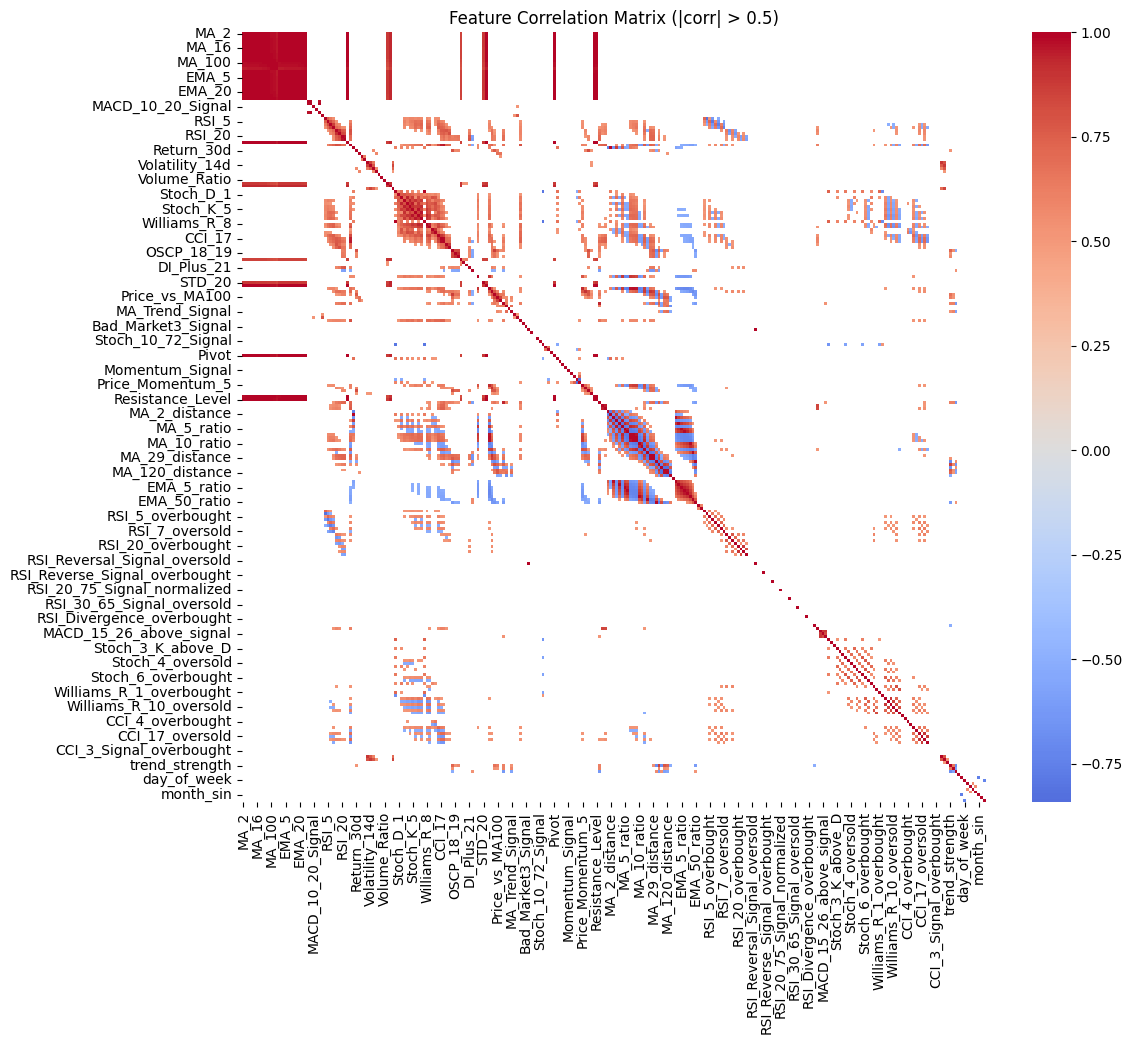

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 상관관계 매트릭스
corr_matrix = X_train_val.corr()
high_corr = np.where(np.abs(corr_matrix) > 0.8)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr) if x != y and x < y]

print("높은 상관관계 (>0.8):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} - {col2}: {corr_val:.3f}")

# 2. VIF (분산팽창계수) - 샘플링해서 계산
sample_size = min(1000, len(X_train_val))
X_sample = X_train_val.sample(sample_size)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_sample.columns
vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i) 
                   for i in range(X_sample.shape[1])]

print(f"\n높은 VIF (>10):")
high_vif = vif_data[vif_data['VIF'] > 30].sort_values('VIF', ascending=False)
print(high_vif.head(30))

# 3. 상관관계 히트맵 (상위 상관관계만)
plt.figure(figsize=(12, 10))
mask = np.abs(corr_matrix) < 0.5
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (|corr| > 0.5)')
plt.show()

In [6]:
import pandas as pd

# Pandas가 출력할 최대 행 수를 None(무제한)으로 설정
pd.set_option('display.max_rows', None)

# 이제 데이터를 다시 출력하면 전체가 보입니다.
print(vif_data)

                            Feature           VIF
0                              MA_2  1.212320e+06
1                              MA_4  2.247634e+06
2                              MA_6  5.887854e+06
3                              MA_8  4.370307e+06
4                             MA_13  1.852684e+06
5                             MA_16  4.713518e+06
6                             MA_20           inf
7                             MA_25  2.713552e+06
8                             MA_29  8.289339e+05
9                             MA_60  2.504390e+05
10                           MA_100  1.188299e+05
11                           MA_120  3.470777e+04
12                           MA_200  8.665095e+02
13                            EMA_3  1.065815e+11
14                            EMA_4  8.537630e+12
15                            EMA_5  1.012045e+14
16                            EMA_6  2.573486e+14
17                            EMA_7  1.125900e+14
18                           EMA_10  1.131558e+13


In [7]:
# =============================================================================
# 셀 4: K-Fold 교차검증 설정
# =============================================================================

# K-Fold 설정
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 클래스 가중치 계산 함수
def calculate_class_weights(y):
    """클래스 가중치 계산"""
    class_counts = y.value_counts().sort_index()
    total_samples = len(y)
    class_weights = {i: total_samples / (len(class_counts) * count) 
                    for i, count in class_counts.items()}
    return class_weights

# 클래스 가중치 확인
class_weights = calculate_class_weights(y_train_val)
print(f"클래스 가중치: {class_weights}")

print(f"K-Fold 교차검증 설정 완료 ({N_FOLDS}폴드)")

import subprocess
import gc
import psutil

def check_gpu_memory():
    """GPU 메모리 사용률 간단히 체크"""
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                               '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
            mem_percent = int(mem_used) / int(mem_total) * 100
            return f"GPU: {gpu_util}% | VRAM: {mem_percent:.1f}%"
        else:
            return "GPU 정보 없음"
    except:
        return "nvidia-smi 없음"

def check_system_memory():
    """시스템 메모리 사용률 체크"""
    mem = psutil.virtual_memory()
    return f"RAM: {mem.percent:.1f}%"

def clear_memory():
    """메모리 정리"""
    gc.collect()
    if USE_GPU:
        try:
            import torch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except:
            pass

print("모니터링 함수 설정 완료")


클래스 가중치: {0.0: 4.222501308215594, 1.0: 0.39595662201285636, 2.0: 4.207968293700459}
K-Fold 교차검증 설정 완료 (5폴드)
모니터링 함수 설정 완료


In [8]:
# =============================================================================
# 셀 5: Optuna 목적 함수 정의
# =============================================================================

def objective_function(trial):
    trial_num = trial.number + 1  # 이 줄을 함수 시작 부분에 추가
    # 훨씬 더 큰 파라미터 범위
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 3, 9),      # 3-6 → 6-15
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
        'gamma': trial.suggest_float('gamma', 0.1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 4),
        'max_leaves': trial.suggest_int('max_leaves', 20, 100),      #
        'max_bin': trial.suggest_int('max_bin', 512, 1024),         # 추가
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'early_stopping_rounds': 100,  # 30 → 100 (더 오래 학습)
        'random_state': RANDOM_STATE,
        'n_jobs': PARALLEL_JOBS,       # 4 → 8
        'verbosity': 0
    }
    
    # GPU 최적화 설정 (더 공격적)
    if USE_GPU:
        params['tree_method'] = 'gpu_hist'
        params['gpu_id'] = 0
        params['predictor'] = 'gpu_predictor'
        params['max_bin'] = trial.suggest_int('max_bin', 512, 1024)  # 하이퍼파라미터로 최적화
        params['single_precision_histogram'] = True  # 추가: 속도 향상
    
    # print(f"시도할 파라미터:")
    # for key, value in params.items():
        # if key not in ['objective', 'num_class', 'eval_metric', 'random_state', 'n_jobs', 'verbosity']:
            # print(f"  {key}: {value}")

    
    # K-Fold 교차검증
    cv_scores = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train_val, y_train_val), 1):
        # print(f"\nFold {fold_num}/{N_FOLDS} 학습 시작 | {check_gpu_memory()} | {check_system_memory()}")
        
        X_train_fold = X_train_val.iloc[train_idx]
        X_val_fold = X_train_val.iloc[val_idx]
        y_train_fold = y_train_val.iloc[train_idx]
        y_val_fold = y_train_val.iloc[val_idx]
        
        fold_class_weights = calculate_class_weights(y_train_fold)
        sample_weights = np.array([fold_class_weights[label] for label in y_train_fold])
        
        # print(f"  학습 데이터 준비 완료 | {check_gpu_memory()}")
        
        # 모델 학습
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            sample_weight=sample_weights,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        # print(f"  Fold {fold_num} 학습 완료 | {check_gpu_memory()}")
        
        # 예측 및 평가
        val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, val_pred, average='macro')
        cv_scores.append(f1)
        
        # print(f"  Fold {fold_num} F1-Score: {f1:.4f} (반복: {model.best_iteration}) | {check_gpu_memory()}")
        
        # 폴드 완료 후 정리
        del model, val_pred
        clear_memory()
    
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    print(f"\nTrial {trial_num} 결과:")
    print(f"  평균 CV F1-Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    print(f"  개별 폴드 점수: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"  Trial 완료 | {check_gpu_memory()} | {check_system_memory()}")
    
    # Trial 완료 후 메모리 정리
    clear_memory()
    
    return mean_cv_score

print("Optuna 목적 함수 정의 완료 (모니터링 및 메모리 정리 포함)")

Optuna 목적 함수 정의 완료 (모니터링 및 메모리 정리 포함)


In [9]:
# GPU 메모리 사용량 극대화 설정
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XGB_CUDA_MEMORY_POOL'] = '8192'  # 8GB GPU 메모리 풀

# 더 큰 데이터 청크로 처리
def optimize_gpu_memory():
    """GPU 메모리 사용량 최적화"""
    try:
        import cupy
        mempool = cupy.get_default_memory_pool()
        mempool.set_limit(size=8 * 1024**3)  # 8GB 제한
        print("GPU 메모리 풀 설정: 8GB")
    except:
        print("CuPy 없음 - XGBoost 내장 GPU 메모리 관리 사용")

optimize_gpu_memory()

CuPy 없음 - XGBoost 내장 GPU 메모리 관리 사용


# 하이퍼파라미터 튜닝

In [11]:
# =============================================================================
# 셀 6: 하이퍼파라미터 최적화 실행
# =============================================================================

print("하이퍼파라미터 최적화 시작...")
print(f"최적화 시도 횟수: {N_TRIALS}회")
print(f"GPU 사용: {USE_GPU}")

# Optuna Study 생성
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE)
)

# 최적화 실행 (콜백으로 진행상황 추가 출력)
def print_best_callback(study, trial):
    """각 trial 후 현재까지 최고 성능 출력"""
    if trial.number > 0:  # 첫 번째 trial이 아닐 때만
        print(f"\n현재까지 최고 성능:")
        print(f"  Best F1-Score: {study.best_value:.4f}")
        print(f"  Best Trial: {study.best_trial.number + 1}")
        # print(f"  남은 시도: {N_TRIALS - trial.number - 1}회")

study.optimize(objective_function, n_trials=N_TRIALS, callbacks=[print_best_callback])

# 결과 저장
best_params = study.best_params
best_cv_score = study.best_value

print(f"\n{'='*60}")
print(f"하이퍼파라미터 최적화 완료!")
print(f"{'='*60}")
print(f"최고 CV F1-Score: {best_cv_score:.4f}")
print(f"최고 성능을 낸 Trial: {study.best_trial.number + 1}")
print(f"최적 파라미터:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Top 5 시도 결과 출력
print(f"\nTop 5 시도 결과:")
sorted_trials = sorted(study.trials, key=lambda x: x.value if x.value else 0, reverse=True)[:5]
for i, trial in enumerate(sorted_trials, 1):
    if trial.value:
        print(f"  {i}. Trial {trial.number + 1}: F1-Score {trial.value:.4f}")


[I 2025-09-18 20:43:52,368] A new study created in memory with name: no-name-6b7bedbf-bffd-4942-ae41-57cb4cf6feea


하이퍼파라미터 최적화 시작...
최적화 시도 횟수: 3회
GPU 사용: True


[I 2025-09-18 20:45:23,003] Trial 0 finished with value: 0.44214402369011624 and parameters: {'max_depth': 5, 'learning_rate': 0.14310000289738825, 'n_estimators': 393, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'colsample_bynode': 0.5290418060840998, 'min_child_weight': 14, 'gamma': 3.0454635575417233, 'reg_alpha': 2.1242177333881367, 'reg_lambda': 0.18027952775362954, 'max_leaves': 98, 'max_bin': 939, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.44214402369011624.



Trial 1 결과:
  평균 CV F1-Score: 0.4421 ± 0.0065
  개별 폴드 점수: ['0.4392', '0.4495', '0.4498', '0.4334', '0.4388']
  Trial 완료 | GPU: 38% | VRAM: 12.7% | RAM: 6.8%


[I 2025-09-18 20:46:38,872] Trial 1 finished with value: 0.42567594755865007 and parameters: {'max_depth': 4, 'learning_rate': 0.05259391401433528, 'n_estimators': 310, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099021, 'colsample_bylevel': 0.8059264473611898, 'colsample_bynode': 0.569746930326021, 'min_child_weight': 8, 'gamma': 1.8951730321390896, 'reg_alpha': 1.3682099526511078, 'reg_lambda': 3.162186249432753, 'max_leaves': 36, 'max_bin': 775, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.44214402369011624.



Trial 2 결과:
  평균 CV F1-Score: 0.4257 ± 0.0052
  개별 폴드 점수: ['0.4220', '0.4303', '0.4334', '0.4209', '0.4217']
  Trial 완료 | GPU: 39% | VRAM: 12.8% | RAM: 6.7%

현재까지 최고 성능:
  Best F1-Score: 0.4421
  Best Trial: 1


[I 2025-09-18 20:48:20,853] Trial 2 finished with value: 0.43657709991034144 and parameters: {'max_depth': 7, 'learning_rate': 0.03387337731622081, 'n_estimators': 126, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797, 'colsample_bylevel': 0.9041986740582306, 'colsample_bynode': 0.6523068845866853, 'min_child_weight': 6, 'gamma': 3.452741829909569, 'reg_alpha': 1.320457481218804, 'reg_lambda': 0.5759491158946374, 'max_leaves': 60, 'max_bin': 529, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.44214402369011624.



Trial 3 결과:
  평균 CV F1-Score: 0.4366 ± 0.0053
  개별 폴드 점수: ['0.4315', '0.4418', '0.4436', '0.4304', '0.4356']
  Trial 완료 | GPU: 34% | VRAM: 12.6% | RAM: 6.8%

현재까지 최고 성능:
  Best F1-Score: 0.4421
  Best Trial: 1

하이퍼파라미터 최적화 완료!
최고 CV F1-Score: 0.4421
최고 성능을 낸 Trial: 1
최적 파라미터:
  max_depth: 5
  learning_rate: 0.14310000289738825
  n_estimators: 393
  subsample: 0.7993292420985183
  colsample_bytree: 0.5780093202212182
  colsample_bylevel: 0.5779972601681014
  colsample_bynode: 0.5290418060840998
  min_child_weight: 14
  gamma: 3.0454635575417233
  reg_alpha: 2.1242177333881367
  reg_lambda: 0.18027952775362954
  max_leaves: 98
  max_bin: 939
  grow_policy: depthwise

Top 5 시도 결과:
  1. Trial 1: F1-Score 0.4421
  2. Trial 3: F1-Score 0.4366
  3. Trial 2: F1-Score 0.4257


In [ ]:
# # # [I 2025-09-11 01:34:06,292] Trial 6 finished with value: 0.7413365575144304 and 
# # # parameters: {'max_depth': 7, 'learning_rate': 0.21684098829466855, 'n_estimators': 833, 
# # # 'subsample': 0.7806385987847482, 'colsample_bytree': 0.8854835899772805, 'colsample_bylevel': 0.7468977981821954, 
# # # 'colsample_bynode': 0.7613664146909971, 'min_child_weight': 7, 'gamma': 0.2033530139527615, 'reg_alpha': 0.32367428097991335, 
# # # 'reg_lambda': 0.2225738241782636, 'max_leaves': 337, 'max_bin': 673, 'grow_policy': 'lossguide'}
# # # 
# # # . Best is trial 5 with value: 0.7519097790801961.

# best_params ={'max_depth': 7,
#             'learning_rate': 0.21684098829466855,
#             'n_estimators': 833,
#             'subsample': 0.7806385987847482,
#             'colsample_bytree': 0.8854835899772805,
#             'colsample_bylevel': 0.7468977981821954,
#             'colsample_bynode': 0.7613664146909971,
#             'min_child_weight': 7,
#             'gamma': 0.2033530139527615,
#             'reg_alpha': 0.32367428097991335,
#             'reg_lambda': 0.2225738241782636,
#             'max_leaves': 337,
#             'max_bin': 673,
#             'grow_policy': 'lossguide'}

In [19]:
best_params

{'max_depth': 5,
 'learning_rate': 0.14310000289738825,
 'n_estimators': 393,
 'subsample': 0.7993292420985183,
 'colsample_bytree': 0.5780093202212182,
 'colsample_bylevel': 0.5779972601681014,
 'colsample_bynode': 0.5290418060840998,
 'min_child_weight': 14,
 'gamma': 3.0454635575417233,
 'reg_alpha': 2.1242177333881367,
 'reg_lambda': 0.18027952775362954,
 'max_leaves': 98,
 'max_bin': 939,
 'grow_policy': 'depthwise'}

In [20]:
from datetime import datetime
import pytz

# 현재 로컬 시간
print(f"현재 로컬 시간: {datetime.now()}")

# UTC 시간  
print(f"현재 UTC 시간: {datetime.utcnow()}")

현재 로컬 시간: 2025-09-18 20:49:51.310109
현재 UTC 시간: 2025-09-19 06:49:51.310231


# 모델 최종학습

In [21]:
# =============================================================================
# 셀 7: 최종 모델 학습 (콜백 제거)
# =============================================================================
print("최종 모델 학습 시작...")
print(f"학습 전 상태 | {check_gpu_memory()} | {check_system_memory()}")

# 메모리 정리
clear_memory()

# 최적 파라미터에 기본 파라미터 추가
final_params = {
    **best_params,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': PARALLEL_JOBS,
    'verbosity': 1
}

# GPU 설정
if USE_GPU:
    final_params['tree_method'] = 'gpu_hist'
    final_params['gpu_id'] = 0
    final_params['predictor'] = 'gpu_predictor'
    final_params['max_bin'] = 1024 
    final_params['single_precision_histogram'] = True
    print("GPU 가속 사용")

print(f"최종 모델 파라미터:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# 샘플 가중치 계산
sample_weights = np.array([class_weights[label] for label in y_train_val])
print(f"클래스 가중치 적용: {class_weights}")
print(f"학습 준비 완료 | {check_gpu_memory()} | {check_system_memory()}")

# 최종 모델 학습 (단순화)
print(f"\n최종 모델 학습 진행...")
final_model = xgb.XGBClassifier(**final_params)

final_model.fit(
    X_train_val, y_train_val,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print(f"\n최종 모델 학습 완료!")
# print(f"최적 반복 수: {final_model.best_iteration}")


최종 모델 학습 시작...
학습 전 상태 | GPU: 14% | VRAM: 13.4% | RAM: 6.7%
GPU 가속 사용
최종 모델 파라미터:
  max_depth: 5
  learning_rate: 0.14310000289738825
  n_estimators: 393
  subsample: 0.7993292420985183
  colsample_bytree: 0.5780093202212182
  colsample_bylevel: 0.5779972601681014
  colsample_bynode: 0.5290418060840998
  min_child_weight: 14
  gamma: 3.0454635575417233
  reg_alpha: 2.1242177333881367
  reg_lambda: 0.18027952775362954
  max_leaves: 98
  max_bin: 1024
  grow_policy: depthwise
  objective: multi:softprob
  num_class: 3
  eval_metric: mlogloss
  random_state: 42
  n_jobs: 1
  verbosity: 1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  single_precision_histogram: True
클래스 가중치 적용: {0.0: 4.222501308215594, 1.0: 0.39595662201285636, 2.0: 4.207968293700459}
학습 준비 완료 | GPU: 14% | VRAM: 13.4% | RAM: 6.7%

최종 모델 학습 진행...
[0]	validation_0-mlogloss:1.07959
[1]	validation_0-mlogloss:1.06313
[2]	validation_0-mlogloss:1.05032
[3]	validation_0-mlogloss:1.03974
[4]	validation_0-mlogloss

# 피쳐중요도 활성화

In [22]:
print(f"학습 완료 후 | {check_gpu_memory()} | {check_system_memory()}")

# 피쳐 중요도
feature_importance = dict(zip(feature_columns, final_model.feature_importances_))
print(f"피쳐 중요도 계산 완료")

# 중간에 GPU 모니터링 원하면 별도 셀에서 실행
print(f"\n현재 GPU 상태: {check_gpu_memory()}")
print(output_dir)

학습 완료 후 | GPU: 4% | VRAM: 13.3% | RAM: 6.7%
피쳐 중요도 계산 완료

현재 GPU 상태: GPU: 4% | VRAM: 13.3%
/workspace/AI모델/projects/coin/models


# 모델저장

In [23]:
# 모델 저장 (수정)
import joblib
import json
import os
import numpy as np

print("모델 저장 중...")

# 모델 저장
model_path = os.path.join(output_dir, 'xgboost_model.pkl')
joblib.dump(final_model, model_path)
print(f"모델 저장: {model_path}")

# 최적 하이퍼파라미터 저장
params_path = os.path.join(output_dir, 'xgboost_best_params.json')
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"최적 파라미터 저장: {params_path}")

# 피쳐 중요도 저장 (float32 → float 변환)
importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
with open(importance_path, 'w') as f:
    json.dump(feature_importance_serializable, f, indent=2)
print(f"피쳐 중요도 저장: {importance_path}")

# 피쳐 리스트 저장
features_path = os.path.join(output_dir, 'feature_list.json')
with open(features_path, 'w') as f:
    json.dump({
        'feature_count': len(feature_columns),
        'feature_list': feature_columns
    }, f, indent=2)
print(f"피쳐 리스트 저장: {features_path}")

print(f"저장 완료! 위치: {output_dir}")

모델 저장 중...
모델 저장: /workspace/AI모델/projects/coin/models/xgboost_model.pkl
최적 파라미터 저장: /workspace/AI모델/projects/coin/models/xgboost_best_params.json
피쳐 중요도 저장: /workspace/AI모델/projects/coin/models/xgboost_feature_importance.json
피쳐 리스트 저장: /workspace/AI모델/projects/coin/models/feature_list.json
저장 완료! 위치: /workspace/AI모델/projects/coin/models


# 모델평가 (Test set)
### 과적합 측정 % 신뢰도
- 대부분의 머신러닝 프로젝트에서는 7-8% 이내를 목표로 함
- 데이터가 적거나 복잡한 문제의 경우 10% 이내도 수용 가능
- 의료, 금융 등 고신뢰성이 필요한 분야는 5% 이내 권장

In [24]:
### 과적합 향상 코드

# =============================================================================
# 셀 8: 개선된 모델 평가
# =============================================================================
def evaluate_model(model, X_train_val, X_test, y_train_val, y_test):
    """모델 평가 (개선된 과적합 측정 포함)"""
    results = {}
    
    # 예측
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    # 평가
    for dataset_name, y_true, y_pred, y_pred_proba in [
        ("Train", y_train_val, train_pred, train_pred_proba),
        ("Test", y_test, test_pred, test_pred_proba)
    ]:
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        # ROC AUC
        try:
            y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
            roc_auc = roc_auc_score(y_true_binarized, y_pred_proba, 
                                  average='macro', multi_class='ovr')
        except:
            roc_auc = np.nan
            
        results[dataset_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'roc_auc': roc_auc
        }
        
        print(f"{dataset_name} 성능:")
        print(f"  정확도: {accuracy:.4f}")
        print(f"  F1 (Macro): {f1_macro:.4f}")
        print(f"  F1 (Weighted): {f1_weighted:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print()
    
    # =============================================================================
    # 개선된 과적합 측정 방법 적용
    # =============================================================================
    
    # 더 정확한 과적합 측정 (Train과 Test 간의 F1 Macro Score 차이)
    train_f1 = results['Train']['f1_macro']
    test_f1 = results['Test']['f1_macro']
    overfitting_gap = train_f1 - test_f1
    
    # CV 점수와의 비교 (기존 방법 유지)
    # results['CV_F1_Score'] = cv_score
    # results['CV_vs_Test_Gap'] = abs(cv_score - test_f1)  # CV와 Test 간 차이
    
    # 과적합 관련 결과 저장
    results['Train_F1_Macro'] = train_f1
    results['Test_F1_Macro'] = test_f1
    results['Overfitting_Gap'] = overfitting_gap  # 개선된 과적합 측정값
    
    # 결과 출력
    print("="*60)
    print("과적합 분석 (개선된 방법)")
    print("="*60)
    print(f"Train F1-Score (Macro): {train_f1:.4f} ({train_f1*100:.1f}%)")
    print(f"Test F1-Score (Macro):  {test_f1:.4f} ({test_f1*100:.1f}%)")
    print(f"과적합 정도 (Train-Test): {overfitting_gap:.4f} ({overfitting_gap*100:.1f}%p)")
    print()
    # print("기존 CV 기반 분석:")
    # print(f"CV F1-Score: {cv_score:.4f}")
    # print(f"CV vs Test 차이: {results['CV_vs_Test_Gap']:.4f} (낮을수록 좋음)")
    print()
    
    # 과적합 수준 판단
    if overfitting_gap < 0.05:  # 5%p 미만
        overfitting_level = "낮음 (양호)"
    elif overfitting_gap < 0.10:  # 5~10%p
        overfitting_level = "보통 (주의)"
    else:  # 10%p 이상
        overfitting_level = "높음 (개선 필요)"
    
    print(f"과적합 수준: {overfitting_level}")
    print("="*60)
    
    return results, test_pred


# =============================================================================
# 모델 평가 실행
# =============================================================================

# CV 점수 확인
print(f"사용 가능한 변수들:")
print(f"- best_params: {best_params}")
# print(f"- study.best_value: {study.best_value}")

# 모델 평가 실행 (개선된 과적합 측정 포함)
evaluation_results, test_predictions = evaluate_model(
    final_model, X_train_val, X_test, y_train_val, y_test
)



사용 가능한 변수들:
- best_params: {'max_depth': 5, 'learning_rate': 0.14310000289738825, 'n_estimators': 393, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'colsample_bynode': 0.5290418060840998, 'min_child_weight': 14, 'gamma': 3.0454635575417233, 'reg_alpha': 2.1242177333881367, 'reg_lambda': 0.18027952775362954, 'max_leaves': 98, 'max_bin': 939, 'grow_policy': 'depthwise'}
Train 성능:
  정확도: 0.7983
  F1 (Macro): 0.6815
  F1 (Weighted): 0.8238
  ROC AUC: 0.9490

Test 성능:
  정확도: 0.6320
  F1 (Macro): 0.4074
  F1 (Weighted): 0.6788
  ROC AUC: 0.6604

과적합 분석 (개선된 방법)
Train F1-Score (Macro): 0.6815 (68.1%)
Test F1-Score (Macro):  0.4074 (40.7%)
과적합 정도 (Train-Test): 0.2741 (27.4%p)


과적합 수준: 높음 (개선 필요)


In [25]:
print("Train 레이블 분포:", np.bincount(y_train_val))
print("Test 레이블 분포:", np.bincount(y_test))

Train 레이블 분포: [ 3185 33965  3196]
Test 레이블 분포: [ 619 5911  590]


# 과적합 원인 분석

In [26]:
# =============================================================================
# 데이터 누출 및 과적합 원인 진단 코드
# =============================================================================

def diagnose_data_leakage(train_df, val_df, test_df, feature_columns):
    """
    데이터 누출 및 과적합 원인 진단
    """
    print("="*60)
    print("데이터 누출 진단")
    print("="*60)
    
    # 1. Future 관련 피처가 실제로 제거되었는지 확인
    future_features = [col for col in feature_columns if 'Future' in col]
    if future_features:
        print(f"⚠️  경고: Future 관련 피처가 여전히 포함됨!")
        print(f"Future 피처들: {future_features}")
    else:
        print("✅ Future 관련 피처 모두 제거됨")
    
    # 2. 시간 정보 확인
    if 'Date' in train_df.columns:
        train_dates = pd.to_datetime(train_df['Date'])
        val_dates = pd.to_datetime(val_df['Date']) if not val_df.empty else None
        test_dates = pd.to_datetime(test_df['Date'])
        
        print(f"\n시간적 데이터 분포:")
        print(f"Train 기간: {train_dates.min()} ~ {train_dates.max()}")
        if val_dates is not None:
            print(f"Val 기간:   {val_dates.min()} ~ {val_dates.max()}")
        print(f"Test 기간:  {test_dates.min()} ~ {test_dates.max()}")
        
        # 시간적 순서 확인
        train_max = train_dates.max()
        test_min = test_dates.min()
        
        if test_min <= train_max:
            print(f"⚠️  심각한 문제: 테스트 데이터에 훈련 데이터보다 이른 날짜가 포함됨!")
            print(f"   Train 최대일: {train_max}")
            print(f"   Test 최소일: {test_min}")
            
            # 겹치는 날짜 확인
            overlapping_dates = set(train_dates.dt.date) & set(test_dates.dt.date)
            if overlapping_dates:
                print(f"   겹치는 날짜 수: {len(overlapping_dates)}개")
                print(f"   겹치는 날짜 샘플: {sorted(overlapping_dates)[:5]}")
        else:
            print("✅ 시간적 순서 올바름 (Train < Test)")
    
    # 3. 타겟 변수 분포 비교
    print(f"\n타겟 변수 분포 비교:")
    
    def print_distribution(name, y):
        dist = y.value_counts(normalize=True).sort_index() * 100
        print(f"{name:10s}: ", end="")
        for label in sorted(dist.index):
            print(f"{label}:{dist[label]:5.1f}% ", end="")
        print()
    
    print_distribution("Train", train_df['Future_Label'])
    if not val_df.empty:
        print_distribution("Val", val_df['Future_Label'])
    print_distribution("Test", test_df['Future_Label'])
    
    # 4. 특정 피처의 분포 확인 (누출 의심)
    suspicious_features = []
    for feature in feature_columns[:10]:  # 처음 10개만 체크
        if feature in train_df.columns and feature in test_df.columns:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            
            if abs(train_mean - test_mean) / (abs(train_mean) + 1e-8) > 2.0:  # 200% 이상 차이
                suspicious_features.append(feature)
    
    if suspicious_features:
        print(f"\n⚠️  분포가 크게 다른 피처들 (누출 의심):")
        for feature in suspicious_features[:5]:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            print(f"   {feature}: Train={train_mean:.4f}, Test={test_mean:.4f}")
    
    # 5. 완전히 동일한 행이 있는지 확인
    print(f"\n데이터 중복 확인:")
    
    # 피처만으로 중복 확인
    train_features = train_df[feature_columns]
    test_features = test_df[feature_columns]
    
    # 해시를 이용한 빠른 중복 검사
    train_hashes = pd.util.hash_pandas_object(train_features, index=False)
    test_hashes = pd.util.hash_pandas_object(test_features, index=False)
    
    duplicate_count = len(set(train_hashes) & set(test_hashes))
    print(f"완전히 동일한 행 수: {duplicate_count}개")
    
    if duplicate_count > 0:
        print(f"⚠️  심각: Train과 Test에 동일한 행이 {duplicate_count}개 존재!")
    
    # 6. 심볼별 분포 확인 (주식 데이터인 경우)
    if 'Symbol' in train_df.columns and 'Symbol' in test_df.columns:
        train_symbols = set(train_df['Symbol'].unique())
        test_symbols = set(test_df['Symbol'].unique())
        common_symbols = train_symbols & test_symbols
        
        print(f"\nSymbol 분포:")
        print(f"Train 심볼 수: {len(train_symbols)}")
        print(f"Test 심볼 수: {len(test_symbols)}")
        print(f"공통 심볼 수: {len(common_symbols)}")
        
        if len(common_symbols) == 0:
            print("⚠️  경고: Train과 Test에 공통 심볼이 없음 (도메인 차이 가능성)")

    return {
        'future_features': future_features,
        'duplicate_rows': duplicate_count,
        'suspicious_features': suspicious_features
    }

# =============================================================================
# 과적합 원인 분석 함수
# =============================================================================

def analyze_overfitting_causes(model, X_train_val, X_test, feature_columns):
    """
    과적합의 구체적 원인 분석
    """
    print("\n" + "="*60)
    print("과적합 원인 분석")
    print("="*60)
    
    # 1. 피처 중요도 분석
    feature_importance = model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 중요 피처:")
    for i, row in feature_imp_df.head(10).iterrows():
        print(f"  {row['feature']:25s}: {row['importance']:.4f}")
    
    # 2. 매우 높은 중요도를 가진 피처 확인 (누출 의심)
    high_importance_threshold = 0.1  # 10% 이상
    high_imp_features = feature_imp_df[feature_imp_df['importance'] > high_importance_threshold]
    
    if not high_imp_features.empty:
        print(f"\n⚠️  매우 높은 중요도 피처들 (누출 의심):")
        for i, row in high_imp_features.iterrows():
            print(f"  {row['feature']:25s}: {row['importance']:.4f}")
    
    # 3. 트리 깊이 및 복잡도 확인
    if hasattr(model, 'get_params'):
        params = model.get_params()
        print(f"\n모델 복잡도 파라미터:")
        complex_params = ['max_depth', 'n_estimators', 'min_child_weight', 
                         'gamma', 'subsample', 'colsample_bytree']
        for param in complex_params:
            if param in params:
                print(f"  {param:20s}: {params[param]}")
    
    # 4. 데이터 분포 비교
    print(f"\n데이터 통계 비교:")
    train_stats = X_train_val.describe()
    test_stats = X_test.describe()
    
    print(f"{'통계':15s} {'Train':>12s} {'Test':>12s} {'차이':>12s}")
    print("-" * 55)
    for stat in ['mean', 'std', 'min', 'max']:
        train_val = train_stats.loc[stat].mean()
        test_val = test_stats.loc[stat].mean()
        diff = abs(train_val - test_val) / (abs(train_val) + 1e-8)
        print(f"{stat:15s} {train_val:12.4f} {test_val:12.4f} {diff:12.2%}")

# =============================================================================
# 실행 코드
# =============================================================================

# 원본 데이터프레임들이 필요합니다
print("데이터 누출 진단을 위해 원본 데이터프레임을 다시 로드합니다...")

# 데이터 다시 로드 (진단용)
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))

# 진단 실행
leakage_results = diagnose_data_leakage(train_df, val_df, test_df, feature_columns)

# 과적합 원인 분석
analyze_overfitting_causes(final_model, X_train_val, X_test, feature_columns)

데이터 누출 진단을 위해 원본 데이터프레임을 다시 로드합니다...
데이터 누출 진단
✅ Future 관련 피처 모두 제거됨

시간적 데이터 분포:
Train 기간: 2015-01-01 00:00:00 ~ 2023-08-27 00:00:00
Val 기간:   2023-08-27 00:00:00 ~ 2024-09-05 00:00:00
Test 기간:  2024-09-05 00:00:00 ~ 2025-09-14 00:00:00
✅ 시간적 순서 올바름 (Train < Test)

타겟 변수 분포 비교:
Train     : 0.0:  7.9% 1.0: 84.2% 2.0:  7.9% 
Val       : 0.0:  7.9% 1.0: 84.2% 2.0:  7.9% 
Test      : 0.0:  8.7% 1.0: 83.0% 2.0:  8.3% 

⚠️  분포가 크게 다른 피처들 (누출 의심):
   MA_2: Train=-0.0695, Test=0.2663
   MA_4: Train=-0.0694, Test=0.2662
   MA_6: Train=-0.0694, Test=0.2660
   MA_8: Train=-0.0693, Test=0.2657
   MA_13: Train=-0.0691, Test=0.2653

데이터 중복 확인:
완전히 동일한 행 수: 0개

Symbol 분포:
Train 심볼 수: 19
Test 심볼 수: 19
공통 심볼 수: 19

과적합 원인 분석
Top 10 중요 피처:
  MA_8                     : 0.0213
  Jungjin_Signal           : 0.0150
  EMA_10                   : 0.0106
  MA_6                     : 0.0099
  MA_3_ratio               : 0.0094
  Volatility_14d           : 0.0092
  MA_2_ratio               : 0.0086
  EMA_5_ratio  

In [27]:
# =============================================================================
# 클래스 가중치 효과 분석 및 문제 진단
# =============================================================================

def analyze_class_weight_effect(model, X_train_val, X_test, y_train_val, y_test, class_weights):
    """
    클래스 가중치가 실제로 효과를 내고 있는지 분석
    """
    print("="*60)
    print("클래스 가중치 효과 분석")
    print("="*60)
    
    # 1. 예측 확률 분포 확인
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    print("예측 결과 분포:")
    print(f"{'데이터셋':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    # 실제 분포
    for name, y_true in [("실제-Train", y_train_val), ("실제-Test", y_test)]:
        counts = y_true.value_counts().sort_index()
        pcts = (counts / len(y_true) * 100)
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # 예측 분포
    for name, y_pred in [("예측-Train", train_pred), ("예측-Test", test_pred)]:
        counts = pd.Series(y_pred).value_counts().sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        # 누락된 클래스 처리
        for i in [0, 1, 2]:
            if i not in counts.index:
                counts[i] = 0
        counts = counts.sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # 2. 예측 확률의 평균 확인
    print(f"\n평균 예측 확률:")
    print(f"{'데이터셋':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    train_prob_mean = train_pred_proba.mean(axis=0)
    test_prob_mean = test_pred_proba.mean(axis=0)
    
    print(f"{'Train':10s} {train_prob_mean[0]:8.3f} {train_prob_mean[1]:8.3f} {train_prob_mean[2]:8.3f}")
    print(f"{'Test':10s} {test_prob_mean[0]:8.3f} {test_prob_mean[1]:8.3f} {test_prob_mean[2]:8.3f}")
    
    # 3. 클래스별 성능 상세 분석
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\n테스트 세트 상세 성능:")
    print(classification_report(y_test, test_pred, 
                              target_names=['Sell(0)', 'Hold(1)', 'Buy(2)']))
    
    print(f"테스트 세트 혼동 행렬:")
    cm = confusion_matrix(y_test, test_pred)
    print(f"{'':8s} {'Sell':>6s} {'Hold':>6s} {'Buy':>6s}")
    class_names = ['Sell', 'Hold', 'Buy']
    for i, row_name in enumerate(class_names):
        print(f"{row_name:8s}", end="")
        for j in range(3):
            print(f"{cm[i,j]:6d}", end="")
        print()
    
    # 4. 클래스 가중치가 제대로 작동하는지 확인
    print(f"\n클래스 가중치 효과 분석:")
    print(f"설정된 가중치: {class_weights}")
    
    # 실제 손실에서 클래스별 기여도 추정
    # (정확한 계산은 모델 내부 접근이 필요하지만, 대략적 추정)
    
    # 만약 모든 클래스를 Hold로 예측했다면?
    naive_pred = np.ones_like(y_test)  # 모든 것을 Hold(1)로 예측
    naive_accuracy = accuracy_score(y_test, naive_pred)
    actual_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"Naive 예측 (모두 Hold): {naive_accuracy:.4f}")
    print(f"실제 모델 정확도: {actual_accuracy:.4f}")
    print(f"개선 정도: {actual_accuracy - naive_accuracy:.4f}")
    
    if actual_accuracy - naive_accuracy < 0.01:  # 1% 미만 개선
        print("⚠️ 경고: 클래스 가중치가 거의 효과를 내지 못하고 있음!")
        return False
    else:
        print("✅ 클래스 가중치가 어느 정도 효과를 내고 있음")
        return True

# =============================================================================
# 더 강력한 클래스 불균형 해결 방법들
# =============================================================================

def suggest_improved_approaches():
    """
    클래스 불균형 문제에 대한 더 강력한 해결책들
    """
    print(f"\n" + "="*60)
    print("클래스 불균형 문제 - 개선된 해결책들")
    print("="*60)
    
    print("1. 더 강한 클래스 가중치 사용:")
    print("   - 현재 가중치를 2-3배 더 강하게 설정")
    print("   - sklearn의 'balanced' 옵션 사용")
    
    print("\n2. 샘플링 기법 적용:")
    print("   - SMOTE: 소수 클래스 오버샘플링")
    print("   - RandomUnderSampler: 다수 클래스 언더샘플링")
    print("   - 조합 방법 (SMOTEENN, SMOTETomek)")
    
    print("\n3. 임계값(Threshold) 조정:")
    print("   - 기본 0.5 대신 클래스별 최적 임계값 찾기")
    print("   - Precision-Recall 커브 활용")
    
    print("\n4. 평가 지표 변경:")
    print("   - Accuracy 대신 Macro F1-Score 사용")
    print("   - 클래스별 F1-Score 개별 확인")
    print("   - Balanced Accuracy 사용")
    
    print("\n5. 앙상블 방법:")
    print("   - BalancedRandomForest")
    print("   - EasyEnsemble")
    print("   - 클래스별 별도 모델 학습")

# =============================================================================
# 강화된 클래스 가중치 실험
# =============================================================================

def train_with_stronger_weights(X_train_val, y_train_val, best_params):
    """
    더 강한 클래스 가중치로 모델 재학습
    """
    print(f"\n" + "="*60)
    print("강화된 클래스 가중치로 재학습")
    print("="*60)
    
    # 1. sklearn의 'balanced' 옵션 시도
    print("1. sklearn 'balanced' 가중치 실험...")
    
    balanced_params = {
        **best_params,
        'objective': 'multi:softprob',
        'num_class': 3,
        'random_state': RANDOM_STATE,
        'eval_metric': 'mlogloss'
    }
    
    # XGBoost는 class_weight를 직접 지원하지 않으므로 sample_weight 사용
    from sklearn.utils.class_weight import compute_sample_weight
    
    # 'balanced' 옵션으로 샘플 가중치 계산
    sample_weights_balanced = compute_sample_weight('balanced', y_train_val)
    
    print(f"Balanced 샘플 가중치 통계:")
    print(f"  평균: {sample_weights_balanced.mean():.3f}")
    print(f"  최소: {sample_weights_balanced.min():.3f}")
    print(f"  최대: {sample_weights_balanced.max():.3f}")
    print(f"  비율 (최대/최소): {sample_weights_balanced.max()/sample_weights_balanced.min():.1f}")
    
    # 2. 수동으로 더 강한 가중치 설정
    print(f"\n2. 수동 강화 가중치 실험...")
    
    # 기존 가중치의 2배로 극값 강화
    enhanced_weights = {
        0: 15.0,  # Sell - 더 강하게
        1: 0.2,   # Hold - 더 약하게  
        2: 15.0   # Buy - 더 강하게
    }
    
    sample_weights_enhanced = np.array([enhanced_weights[label] for label in y_train_val])
    
    print(f"강화된 클래스 가중치: {enhanced_weights}")
    print(f"강화된 샘플 가중치 통계:")
    print(f"  평균: {sample_weights_enhanced.mean():.3f}")
    print(f"  최소: {sample_weights_enhanced.min():.3f}")
    print(f"  최대: {sample_weights_enhanced.max():.3f}")
    print(f"  비율 (최대/최소): {sample_weights_enhanced.max()/sample_weights_enhanced.min():.1f}")
    
    return sample_weights_balanced, sample_weights_enhanced, balanced_params

# =============================================================================
# 실행 코드
# =============================================================================

# 현재 모델의 클래스 가중치 효과 분석
print("현재 모델의 클래스 가중치 효과를 분석합니다...")
weight_is_effective = analyze_class_weight_effect(
    final_model, X_train_val, X_test, y_train_val, y_test, class_weights
)

# 개선 방법 제안
suggest_improved_approaches()

# 더 강한 가중치로 실험할 준비
if not weight_is_effective:
    print(f"\n클래스 가중치 효과가 부족합니다. 더 강한 방법을 시도해보세요.")
    sample_weights_balanced, sample_weights_enhanced, enhanced_params = train_with_stronger_weights(
        X_train_val, y_train_val, best_params
    )
    
    print(f"\n다음 단계:")
    print(f"1. 위의 강화된 가중치로 모델을 다시 학습")
    print(f"2. SMOTE 등 샘플링 기법 적용")
    print(f"3. 임계값 조정으로 예측 최적화")
else:
    print(f"\n클래스 가중치가 효과를 내고 있지만, 추가 개선이 필요할 수 있습니다.")

현재 모델의 클래스 가중치 효과를 분석합니다...
클래스 가중치 효과 분석
예측 결과 분포:
데이터셋        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
실제-Train       7.9%    84.2%     7.9%
실제-Test        8.7%    83.0%     8.3%
예측-Train      17.8%    66.1%    16.2%
예측-Test       19.4%    65.7%    14.9%

평균 예측 확률:
데이터셋        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
Train         0.247    0.502    0.251
Test          0.267    0.474    0.259

테스트 세트 상세 성능:
              precision    recall  f1-score   support

     Sell(0)       0.18      0.40      0.25       619
     Hold(1)       0.87      0.69      0.77      5911
      Buy(2)       0.16      0.28      0.20       590

    accuracy                           0.63      7120
   macro avg       0.40      0.46      0.41      7120
weighted avg       0.75      0.63      0.68      7120

테스트 세트 혼동 행렬:
           Sell   Hold    Buy
Sell       247   288    84
Hold      1016  4085   810
Buy        115   307   168

클래스 가중치 효과 분석:
설정된 가중치: {0.0:

In [18]:
# ## 기존코드

# # =============================================================================
# # 셀 8: 모델 평가
# # =============================================================================

# def evaluate_model(model, X_train_val, X_test, y_train_val, y_test, cv_score):
#     """모델 평가"""
    
#     results = {}
    
#     # 예측
#     train_pred = model.predict(X_train_val)
#     test_pred = model.predict(X_test)
    
#     train_pred_proba = model.predict_proba(X_train_val)
#     test_pred_proba = model.predict_proba(X_test)
    
#     # 평가
#     for dataset_name, y_true, y_pred, y_pred_proba in [
#         ("Train", y_train_val, train_pred, train_pred_proba),
#         ("Test", y_test, test_pred, test_pred_proba)
#     ]:
#         accuracy = accuracy_score(y_true, y_pred)
#         f1_macro = f1_score(y_true, y_pred, average='macro')
#         f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
#         # ROC AUC
#         try:
#             y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
#             roc_auc = roc_auc_score(y_true_binarized, y_pred_proba, average='macro', multi_class='ovr')
#         except:
#             roc_auc = np.nan
        
#         results[dataset_name] = {
#             'accuracy': accuracy,
#             'f1_macro': f1_macro,
#             'f1_weighted': f1_weighted,
#             'roc_auc': roc_auc
#         }
        
#         print(f"{dataset_name} 성능:")
#         print(f"  정확도: {accuracy:.4f}")
#         print(f"  F1 (Macro): {f1_macro:.4f}")
#         print(f"  F1 (Weighted): {f1_weighted:.4f}")
#         print(f"  ROC AUC: {roc_auc:.4f}")
#         print()
    
#     # CV 점수와 비교
#     results['CV_F1_Score'] = cv_score
#     results['Overfitting'] = abs(cv_score - results['Test']['f1_macro'])
    
#     print(f"CV F1-Score: {cv_score:.4f}")
#     print(f"과적합 정도: {results['Overfitting']:.4f} (낮을수록 좋음)")
    
#     return results, test_pred

# # # 옵튜나 완료시, 모델 평가 실행
# # evaluation_results, test_predictions = evaluate_model(
# #     final_model, X_train_val, X_test, y_train_val, y_test, best_cv_score
# # )

# # 옵튜나 진행도중, 모델평가실행
# # CV 점수 확인
# print(f"사용 가능한 변수들:")
# print(f"- best_params: {best_params}")
# print(f"- study.best_value: {study.best_value}")

# # 모델 평가 실행 (study.best_value 사용)
# evaluation_results, test_predictions = evaluate_model(
#     final_model, X_train_val, X_test, y_train_val, y_test, study.best_value
# )

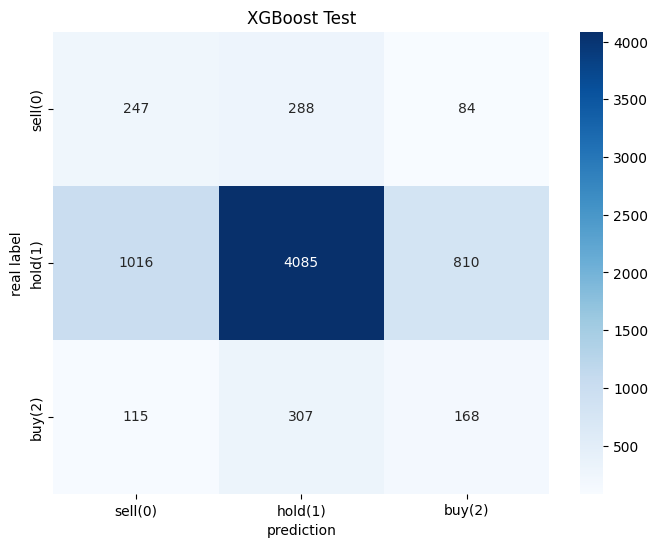

클래스별 정확도:
  sell(0): 0.3990
  hold(1): 0.6911
  buy(2): 0.2847


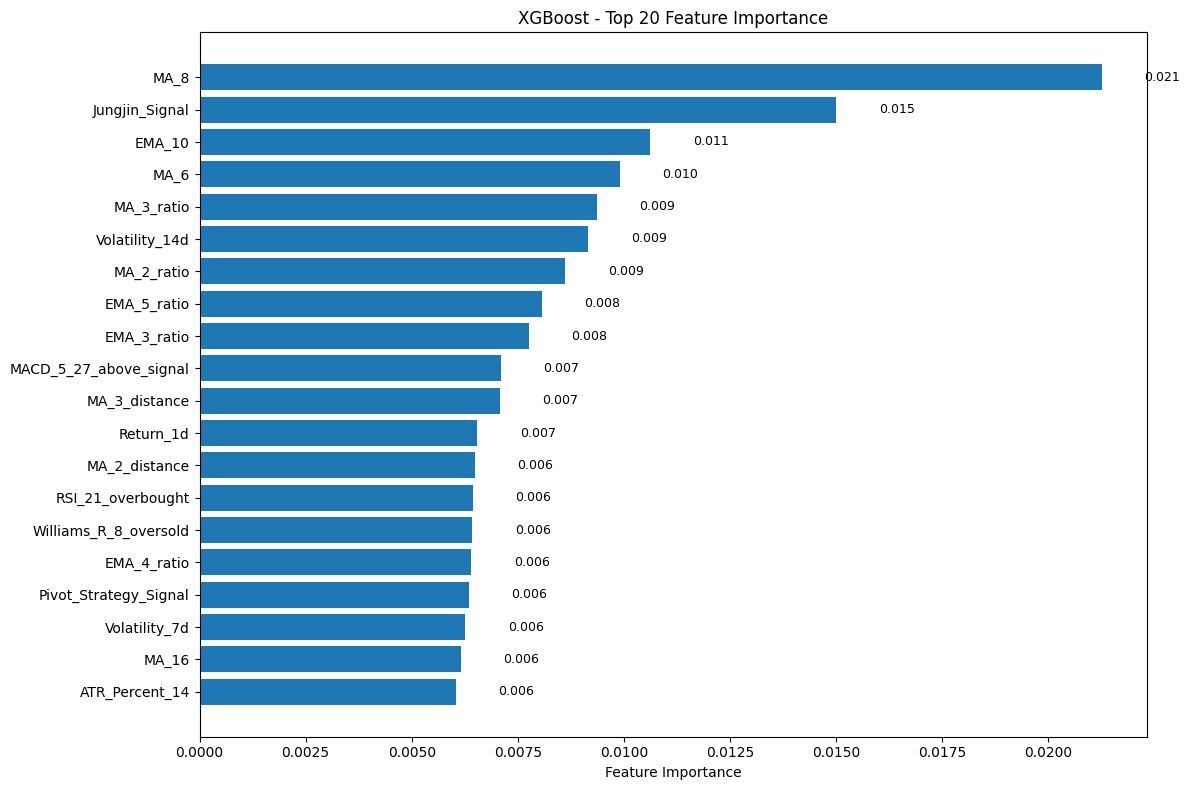

Top 20 중요 피쳐:
   1. MA_8: 0.0213
   2. Jungjin_Signal: 0.0150
   3. EMA_10: 0.0106
   4. MA_6: 0.0099
   5. MA_3_ratio: 0.0094
   6. Volatility_14d: 0.0092
   7. MA_2_ratio: 0.0086
   8. EMA_5_ratio: 0.0081
   9. EMA_3_ratio: 0.0078
  10. MACD_5_27_above_signal: 0.0071
  11. MA_3_distance: 0.0071
  12. Return_1d: 0.0065
  13. MA_2_distance: 0.0065
  14. RSI_21_overbought: 0.0064
  15. Williams_R_8_oversold: 0.0064
  16. EMA_4_ratio: 0.0064
  17. Pivot_Strategy_Signal: 0.0063
  18. Volatility_7d: 0.0063
  19. MA_16: 0.0062
  20. ATR_Percent_14: 0.0060


In [28]:
# =============================================================================
# 셀 9: 혼동 행렬 시각화
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """혼동 행렬 시각화"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    
    # 정규화된 혼동 행렬도 표시
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 히트맵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['sell(0)', 'hold(1)', 'buy(2)'],
               yticklabels=['sell(0)', 'hold(1)', 'buy(2)'])
    plt.title('XGBoost Test')
    plt.xlabel('prediction')
    plt.ylabel('real label')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 클래스별 정확도
    print("클래스별 정확도:")
    for i, class_name in enumerate(['sell(0)', 'hold(1)', 'buy(2)']):
        accuracy = cm[i, i] / cm[i].sum()
        print(f"  {class_name}: {accuracy:.4f}")

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, test_predictions, 
                     save_path=os.path.join(output_dir, 'confusion_matrix.png'))

# =============================================================================
# 셀 10: 피쳐 중요도 시각화
# =============================================================================

def plot_feature_importance(feature_importance, top_n=20, save_path=None):
    """피쳐 중요도 시각화"""
    
    # 상위 N개 피쳐
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    features, importances = zip(*sorted_features)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(features)), importances)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Feature Importance')
    plt.title(f'XGBoost - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, (bar, importance) in enumerate(zip(bars, importances)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 상위 피쳐들 출력
    print(f"Top {top_n} 중요 피쳐:")
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"  {i:2d}. {feature}: {importance:.4f}")

# 피쳐 중요도 시각화
plot_feature_importance(feature_importance, top_n=20, 
                       save_path=os.path.join(output_dir, 'feature_importance.png'))



In [29]:
# =============================================================================
# 셀 11: 결과 저장
# =============================================================================

# =============================================================================
# 셀 11: 결과 저장 (수정)
# =============================================================================
def save_results(model, best_params, evaluation_results, feature_importance, output_dir):
    """결과 저장 (JSON 직렬화 문제 해결)"""
    
    print("결과 저장 중...")
    
    # 모델 저장
    model_path = os.path.join(output_dir, 'xgboost_model.pkl')
    joblib.dump(model, model_path)
    print(f"  모델 저장: {model_path}")
    
    # 최적 하이퍼파라미터 저장
    params_path = os.path.join(output_dir, 'xgboost_best_params.json')
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    print(f"  최적 파라미터 저장: {params_path}")
    
    # 평가 결과 저장 (numpy 타입 변환)
    results_path = os.path.join(output_dir, 'xgboost_results.json')
    evaluation_results_serializable = {}
    for key, value in evaluation_results.items():
        if isinstance(value, dict):
            evaluation_results_serializable[key] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                                                   for k, v in value.items()}
        else:
            evaluation_results_serializable[key] = float(value) if isinstance(value, (np.float32, np.float64)) else value
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_results_serializable, f, indent=2)
    print(f"  평가 결과 저장: {results_path}")
    
    # 피쳐 중요도 저장 (float32 → float 변환)
    importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
    feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
    with open(importance_path, 'w') as f:
        json.dump(feature_importance_serializable, f, indent=2)
    print(f"  피쳐 중요도 저장: {importance_path}")
    
    # 피쳐 리스트 저장
    features_path = os.path.join(output_dir, 'feature_list.json')
    with open(features_path, 'w') as f:
        json.dump({
            'feature_count': len(feature_columns),
            'feature_list': feature_columns
        }, f, indent=2)
    print(f"  피쳐 리스트 저장: {features_path}")

# 결과 저장 실행
save_results(final_model, best_params, evaluation_results, feature_importance, output_dir)

# =============================================================================
# 셀 12: 최종 요약
# =============================================================================

print("\n" + "="*80)
print("XGBoost 주식 3진분류 모델 학습 완료")
print("="*80)

print(f"완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"최종 테스트 F1-Score: {evaluation_results['Test']['f1_macro']:.4f}")
print(f"최종 테스트 정확도: {evaluation_results['Test']['accuracy']:.4f}")
# print(f"CV F1-Score: {evaluation_results['CV_F1_Score']:.4f}")
# print(f"과적합 정도: {evaluation_results['Overfitting']:.4f}")

print(f"\n저장된 파일들:")
print(f"  - 모델: {output_dir}/xgboost_model.pkl")
print(f"  - 하이퍼파라미터: {output_dir}/xgboost_best_params.json")
print(f"  - 평가 결과: {output_dir}/xgboost_results.json")
print(f"  - 피쳐 중요도: {output_dir}/xgboost_feature_importance.json")

print("\n다음 단계: CatBoost 모델 학습 또는 모델 앙상블")
print("="*80)

결과 저장 중...
  모델 저장: /workspace/AI모델/projects/coin/models/xgboost_model.pkl
  최적 파라미터 저장: /workspace/AI모델/projects/coin/models/xgboost_best_params.json
  평가 결과 저장: /workspace/AI모델/projects/coin/models/xgboost_results.json
  피쳐 중요도 저장: /workspace/AI모델/projects/coin/models/xgboost_feature_importance.json
  피쳐 리스트 저장: /workspace/AI모델/projects/coin/models/feature_list.json

XGBoost 주식 3진분류 모델 학습 완료
완료 시간: 2025-09-18 20:51:36
최종 테스트 F1-Score: 0.4074
최종 테스트 정확도: 0.6320

저장된 파일들:
  - 모델: /workspace/AI모델/projects/coin/models/xgboost_model.pkl
  - 하이퍼파라미터: /workspace/AI모델/projects/coin/models/xgboost_best_params.json
  - 평가 결과: /workspace/AI모델/projects/coin/models/xgboost_results.json
  - 피쳐 중요도: /workspace/AI모델/projects/coin/models/xgboost_feature_importance.json

다음 단계: CatBoost 모델 학습 또는 모델 앙상블


# 최종테스트 + 백테스팅용 데이터 만들기

In [30]:
### test  full data 만들기 - date, close 등등 모두포함
# 학습용 전체데이터 (Train+Val+Test)로드 후 test set범위만 추출
train_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/xgboost_training_data.csv'
full_data = pd.read_csv(train_path)

# 시계열 순서에 맞게 추출
full_data = full_data.sort_values('Date')

# 기존 B00_00코드에서 split_time_series_data() 함수와 동일한 비율(70:15:15)로 분할점 계산
# test set범위만 추출
n = len(full_data)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
test_data_full = full_data.iloc[val_end:].copy()

# test(피쳐 다 있는 버전) set 저장
test_output_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_full.csv'
test_data_full.to_csv(test_output_path, index=False)

# 날짜 : 2021.09.13~, 종목 : CVX 행부터 나오면 됨 : C00_00 스크립트 참고

In [31]:
# =============================================================================
# 백테스팅 1단계: 데이터 로드 및 예측 실행
# =============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("백테스팅 1단계: 데이터 로드 및 예측 실행")
print("=" * 60)

# 1. test_data_full.csv 로드 (윗 셀에서 생성)
test_data_full_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_full.csv'
test_data_full = pd.read_csv(test_data_full_path)

print(f"테스트 데이터 로드 완료: {test_data_full.shape}")
print(f"날짜 범위: {test_data_full['Date'].min()} ~ {test_data_full['Date'].max()}")
print(f"종목 수: {test_data_full['Symbol'].nunique()}")
print(f"종목 리스트: {test_data_full['Symbol'].unique()}")

# 2. Prediction을 위해, 학습시 사용했던 피쳐만 추출 (이미 셀3에서 정의한 feature_columns 사용)
print(f"\n학습용 피쳐 추출...")
print(f"전체 컬럼 수: {len(test_data_full.columns)}")
print(f"사용할 피쳐 수: {len(feature_columns)}")


백테스팅 1단계: 데이터 로드 및 예측 실행
테스트 데이터 로드 완료: (7120, 386)
날짜 범위: 2024-09-05 ~ 2025-09-14
종목 수: 19
종목 리스트: ['BTC' 'SOL' 'DOT' 'AVAX' 'ICP' 'XRP' 'UNI7083' 'TRX' 'LTC' 'ADA' 'SHIB'
 'ETH' 'TON11419' 'NEAR' 'BCH' 'USDC' 'DOGE' 'USDT' 'BNB']

학습용 피쳐 추출...
전체 컬럼 수: 386
사용할 피쳐 수: 263


## 모델예측(최종test)

In [32]:

# 피쳐 데이터 준비
X_backtest = test_data_full[feature_columns].fillna(0)
X_backtest = X_backtest.replace([np.inf, -np.inf], 0)

print(f"백테스팅용 피쳐 데이터: {X_backtest.shape}")

# 3. 모델로 예측 실행
print(f"\n예측 실행 중...")

# 라벨예측
predictions = final_model.predict(X_backtest)
# 형태: NumPy 1D 배열
# 예시: array([1, 2, 0, 1, 2, 0, ...])  # 길이 = 샘플 수 : (12543,) 같은 형태

# 확률예측
prediction_probabilities = final_model.predict_proba(X_backtest) # (12543, 3) 같은 형태
# 형태: NumPy 2D 배열 (샘플 수 × 클래스 수)
# 예시: array([[0.2, 0.7, 0.1],   # 첫 번째 샘플: Sell=0.2, Hold=0.7, Buy=0.1
#              [0.1, 0.3, 0.6],   # 두 번째 샘플: Sell=0.1, Hold=0.3, Buy=0.6
#              ...])

print(f"예측 완료!")
print(f"예측 결과 분포:")
unique, counts = np.unique(predictions, return_counts=True)
for label, count in zip(unique, counts):
    label_name = {0: 'Sell', 1: 'Hold', 2: 'Buy'}[int(label)]
    pct = count / len(predictions) * 100
    print(f"  {int(label)} ({label_name}): {count:,}개 ({pct:.1f}%)")

백테스팅용 피쳐 데이터: (7120, 263)

예측 실행 중...
예측 완료!
예측 결과 분포:
  0 (Sell): 1,378개 (19.4%)
  1 (Hold): 4,680개 (65.7%)
  2 (Buy): 1,062개 (14.9%)


In [33]:

# 4. 예측 결과를 원본 데이터에 추가
# 1D 배열을 데이터프레임 컬럼으로 추가
test_data_full['Predicted_Label'] = predictions

# 2D 배열에서 각 클래스별로 컬럼 추가
test_data_full['Pred_Prob_Sell'] = prediction_probabilities[:, 0]
test_data_full['Pred_Prob_Hold'] = prediction_probabilities[:, 1]
test_data_full['Pred_Prob_Buy'] = prediction_probabilities[:, 2]

# 예측 신호를 텍스트로 변환
label_map = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
test_data_full['Predicted_Action'] = test_data_full['Predicted_Label'].map(label_map)

print(f"\n예측 결과가 추가된 데이터: {test_data_full.shape}")

# 5. 실제 라벨과 비교 (검증용)
if 'Future_Label' in test_data_full.columns:
    actual_labels = test_data_full['Future_Label']
    test_accuracy = accuracy_score(actual_labels, predictions)
    test_f1 = f1_score(actual_labels, predictions, average='macro')
    
    print(f"\n예측 성능 검증:")
    print(f"  정확도: {test_accuracy:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    
    print(f"\n상세 분류 보고서:")
    print(classification_report(actual_labels, predictions, 
                               target_names=['Sell', 'Hold', 'Buy']))

# 6. 예측 결과가 추가된 전체 데이터 저장 
output_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_with_predictions.csv'
test_data_full.to_csv(output_path, index=False)
print(f"\n예측 결과가 추가된 데이터 저장: {output_path}")

# 7. 백테스팅용 핵심 데이터만 추출
backtest_data = test_data_full[['Date', 'Symbol', 'Close', 'Predicted_Label', 
                               'Predicted_Action', 'Pred_Prob_Sell', 
                               'Pred_Prob_Hold', 'Pred_Prob_Buy']].copy()

# Date 컬럼을 datetime으로 변환
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

# 시간순 정렬
backtest_data = backtest_data.sort_values(['Symbol', 'Date']).reset_index(drop=True)

print(f"\n백테스팅용 데이터 준비 완료: {backtest_data.shape}")
print(f"샘플 데이터:")
print(backtest_data.head(10))

# 8. 백테스팅용 간단 데이터도 별도 저장
simple_backtest_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/only_prediction_data.csv'
backtest_data.to_csv(simple_backtest_path, index=False)
print(f"백테스팅용 간단 데이터 저장: {simple_backtest_path}")

print(f"\n1단계 완료!")


예측 결과가 추가된 데이터: (7120, 391)

예측 성능 검증:
  정확도: 0.6320
  F1 Score: 0.4074

상세 분류 보고서:
              precision    recall  f1-score   support

        Sell       0.18      0.40      0.25       619
        Hold       0.87      0.69      0.77      5911
         Buy       0.16      0.28      0.20       590

    accuracy                           0.63      7120
   macro avg       0.40      0.46      0.41      7120
weighted avg       0.75      0.63      0.68      7120


예측 결과가 추가된 데이터 저장: /workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_with_predictions.csv

백테스팅용 데이터 준비 완료: (7120, 8)
샘플 데이터:
        Date Symbol     Close  Predicted_Label Predicted_Action  \
0 2024-09-05    ADA  0.325062                1             Hold   
1 2024-09-06    ADA  0.314718                1             Hold   
2 2024-09-07    ADA  0.325073                1             Hold   
3 2024-09-08    ADA  0.338659                0             Sell   
4 2024-09-09    ADA  0.343406                0             Se

In [34]:
display(test_data_full.head(10))
display(test_data_full.tail(10))

,Open,High,Low,Close,Volume,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_10,MA_13,MA_16,MA_20,MA_25,MA_29,MA_50,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_26,EMA_50,MACD,MACD_Signal,MACD_Histogram,MACD_10_20,MACD_10_20_Signal,MACD_15_26,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_4,RSI_5,RSI_6,RSI_7,RSI_12,RSI_14,RSI_20,RSI_21,BB_Middle_20,BB_Upper_20,BB_Lower_20,BB_Width_20,BB_Position_20,Return_1d,Return_3d,Return_7d,Return_14d,Return_30d,Return_90d,Return_180d,Return_365d,Cumulative_Return,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_20,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,True_Range,ATR_14,ATR_Percent_14,Stoch_K_1,Stoch_D_1,Stoch_K_3,Stoch_D_3,Stoch_K_4,Stoch_D_4,Stoch_K_5,Stoch_D_5,Stoch_K_6,Stoch_D_6,Stoch_K_14,Stoch_D_14,Williams_R_1,Williams_R_8,Williams_R_10,Williams_R_14,Williams_R,CCI_3,CCI_4,CCI_10,CCI_17,CCI_20,CCI,MFI_11,MFI_14,MFI,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,ADX_21,Price_ROC_3,STD_1,STD_20,Highest_3,Lowest_3,Highest_7,Lowest_7,Highest_8,Lowest_8,Highest_10,Lowest_10,Highest_11,Lowest_11,Highest_16,Lowest_16,Highest_17,Lowest_17,Highest_28,Lowest_28,Price_vs_MA7,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,MACD_Signal_Cross,Bad_Market3_Signal,RSI_Reversal_Signal,RSI_Extreme_Signal,RSI_Reverse_Signal,RSI_20_75_Signal,RSI_22_78_Signal,RSI_30_65_Signal,RSI_12_50_Signal,Williams_CCI_Signal,CCI_Oversold_Signal,CCI_3_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,Support1,Resistance1,Pivot_Strategy_Signal,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Volume_Breakout_Signal,Momentum_Signal,Price_ROC_3_Signal,Volatility_Signal,Composite_Signal_Avg,Buy_Signal_Count,Sell_Signal_Count,Net_Signal_Score,Final_Composite_Signal,Price_Momentum_5,Price_Momentum_10,Price_Momentum_20,Volatility_20,Volatility_Ratio,RSI_Divergence,MACD_Cross,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,Composite_Score,Future_1d,Future_3d,Future_7d,Future_14d,Future_30d,Future_90d,Future_180d,Future_365d,Label,Label_Name,Optimized_Label,Optimized_Label_Name,Close_log_return,Close_return,Open_log_return,Open_return,High_log_return,High_return,Low_log_return,Low_return,MA_2_ratio,MA_2_distance,MA_3_ratio,MA_3_distance,MA_4_ratio,MA_4_distance,MA_5_ratio,MA_5_distance,MA_6_ratio,MA_6_distance,MA_7_ratio,MA_7_distance,MA_8_ratio,MA_8_distance,MA_10_ratio,MA_10_distance,MA_13_ratio,MA_13_distance,MA_16_ratio,MA_16_distance,MA_20_ratio,MA_20_distance,MA_25_ratio,MA_25_distance,MA_29_ratio,MA_29_distance,MA_50_ratio,MA_50_distance,MA_60_ratio,MA_60_distance,MA_100_ratio,MA_100_distance,MA_120_ratio,MA_120_distance,MA_200_ratio,MA_200_distance,MA_Cross_3_25_Signal_ratio,MA_Cross_3_25_Signal_distance,MA_Trend_Signal_ratio,MA_Trend_Signal_distance,EMA_3_ratio,EMA_4_ratio,EMA_5_ratio,EMA_6_ratio,EMA_7_ratio,EMA_10_ratio,EMA_12_ratio,EMA_20_ratio,EMA_24_ratio,EMA_26_ratio,EMA_50_ratio,EMA_Cross_5_20_Signal_ratio,EMA_Cross_6_24_Signal_ratio,BB_relative_position,BB_upper_distance,BB_lower_distance,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_4_normalized,RSI_5_overbought,RSI_5_oversold,RSI_5_normalized,RSI_6_overbought,RSI_6_oversold,RSI_6_normalized,RSI_7_overbought,RSI_7_oversold,RSI_7_normalized,RSI_12_overbought,RSI_12_oversold,RSI_12_normalized,RSI_14_overbought,RSI_14_oversold,RSI_14_normalized,RSI_20_overbought,RSI_20_oversold,RSI_20_normalized,RSI_21_overbought,RSI_21_oversold,RSI_21_normalized,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_oversold,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_overbought,RSI_Extreme_Signal_oversold,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_ove

,Open,High,Low,Close,Volume,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_10,MA_13,MA_16,MA_20,MA_25,MA_29,MA_50,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_26,EMA_50,MACD,MACD_Signal,MACD_Histogram,MACD_10_20,MACD_10_20_Signal,MACD_15_26,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_4,RSI_5,RSI_6,RSI_7,RSI_12,RSI_14,RSI_20,RSI_21,BB_Middle_20,BB_Upper_20,BB_Lower_20,BB_Width_20,BB_Position_20,Return_1d,Return_3d,Return_7d,Return_14d,Return_30d,Return_90d,Return_180d,Return_365d,Cumulative_Return,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_20,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,True_Range,ATR_14,ATR_Percent_14,Stoch_K_1,Stoch_D_1,Stoch_K_3,Stoch_D_3,Stoch_K_4,Stoch_D_4,Stoch_K_5,Stoch_D_5,Stoch_K_6,Stoch_D_6,Stoch_K_14,Stoch_D_14,Williams_R_1,Williams_R_8,Williams_R_10,Williams_R_14,Williams_R,CCI_3,CCI_4,CCI_10,CCI_17,CCI_20,CCI,MFI_11,MFI_14,MFI,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,ADX_21,Price_ROC_3,STD_1,STD_20,Highest_3,Lowest_3,Highest_7,Lowest_7,Highest_8,Lowest_8,Highest_10,Lowest_10,Highest_11,Lowest_11,Highest_16,Lowest_16,Highest_17,Lowest_17,Highest_28,Lowest_28,Price_vs_MA7,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,MACD_Signal_Cross,Bad_Market3_Signal,RSI_Reversal_Signal,RSI_Extreme_Signal,RSI_Reverse_Signal,RSI_20_75_Signal,RSI_22_78_Signal,RSI_30_65_Signal,RSI_12_50_Signal,Williams_CCI_Signal,CCI_Oversold_Signal,CCI_3_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,Support1,Resistance1,Pivot_Strategy_Signal,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Volume_Breakout_Signal,Momentum_Signal,Price_ROC_3_Signal,Volatility_Signal,Composite_Signal_Avg,Buy_Signal_Count,Sell_Signal_Count,Net_Signal_Score,Final_Composite_Signal,Price_Momentum_5,Price_Momentum_10,Price_Momentum_20,Volatility_20,Volatility_Ratio,RSI_Divergence,MACD_Cross,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,Composite_Score,Future_1d,Future_3d,Future_7d,Future_14d,Future_30d,Future_90d,Future_180d,Future_365d,Label,Label_Name,Optimized_Label,Optimized_Label_Name,Close_log_return,Close_return,Open_log_return,Open_return,High_log_return,High_return,Low_log_return,Low_return,MA_2_ratio,MA_2_distance,MA_3_ratio,MA_3_distance,MA_4_ratio,MA_4_distance,MA_5_ratio,MA_5_distance,MA_6_ratio,MA_6_distance,MA_7_ratio,MA_7_distance,MA_8_ratio,MA_8_distance,MA_10_ratio,MA_10_distance,MA_13_ratio,MA_13_distance,MA_16_ratio,MA_16_distance,MA_20_ratio,MA_20_distance,MA_25_ratio,MA_25_distance,MA_29_ratio,MA_29_distance,MA_50_ratio,MA_50_distance,MA_60_ratio,MA_60_distance,MA_100_ratio,MA_100_distance,MA_120_ratio,MA_120_distance,MA_200_ratio,MA_200_distance,MA_Cross_3_25_Signal_ratio,MA_Cross_3_25_Signal_distance,MA_Trend_Signal_ratio,MA_Trend_Signal_distance,EMA_3_ratio,EMA_4_ratio,EMA_5_ratio,EMA_6_ratio,EMA_7_ratio,EMA_10_ratio,EMA_12_ratio,EMA_20_ratio,EMA_24_ratio,EMA_26_ratio,EMA_50_ratio,EMA_Cross_5_20_Signal_ratio,EMA_Cross_6_24_Signal_ratio,BB_relative_position,BB_upper_distance,BB_lower_distance,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_4_normalized,RSI_5_overbought,RSI_5_oversold,RSI_5_normalized,RSI_6_overbought,RSI_6_oversold,RSI_6_normalized,RSI_7_overbought,RSI_7_oversold,RSI_7_normalized,RSI_12_overbought,RSI_12_oversold,RSI_12_normalized,RSI_14_overbought,RSI_14_oversold,RSI_14_normalized,RSI_20_overbought,RSI_20_oversold,RSI_20_normalized,RSI_21_overbought,RSI_21_oversold,RSI_21_normalized,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_oversold,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_overbought,RSI_Extreme_Signal_oversold,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_ove

# 종목별 저장 : 예측컬럼이 포함된 csv 종목별로 저장

In [35]:
# =============================================================================
# 종목별 예측 결과 CSV 파일 생성
# =============================================================================

import pandas as pd
import os

print("종목별 예측 결과 CSV 파일 생성")
print("=" * 60)

# 1. backtest_data 로드 
# backtest_data가 없다면 아래 주석 해제
backtest_data_path = '/workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_with_predictions.csv'
backtest_data = pd.read_csv(backtest_data_path)
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

종목별 예측 결과 CSV 파일 생성


In [36]:
# 원본 백테스팅 데이터 경로
backtest_dir = '/workspace/AI모델/projects/coin/data/xgboost_B_major/backtest_data'

# 이 폴더에는 각 종목별로 원본 Close 가격이 저장되어 있음:
# AAPL_backtest.csv, MSFT_backtest.csv 등...

In [37]:
import pandas as pd
import os
import glob

# 1. 예측 데이터 로드
prediction_data = pd.read_csv('/workspace/AI모델/projects/coin/data/xgboost_B_major/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

# 2. 백테스팅 원본 데이터 폴더
backtest_dir = '/workspace/AI모델/projects/coin/data/xgboost_B_major/backtest_data'
backtest_files = glob.glob(os.path.join(backtest_dir, '*_backtest.csv'))

# 3. 종목별로 원본 가격 + 예측 결합
output_dir = '/workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data'
os.makedirs(output_dir, exist_ok=True)

for backtest_file in backtest_files:
    # 종목명 추출
    filename = os.path.basename(backtest_file)
    symbol = filename.replace('_backtest.csv', '')
    
    print(f"처리 중: {symbol}")
    
    # 원본 데이터 로드 (실제 Close 가격)
    original_data = pd.read_csv(backtest_file)
    original_data['Date'] = pd.to_datetime(original_data['Date'])
    
    # Symbol 컬럼 추가 (백테스팅 데이터에 없으므로)
    original_data['Symbol'] = symbol
    
    # 해당 종목의 예측 데이터
    symbol_predictions = predictions[predictions['Symbol'] == symbol].copy()
    
    print(f"  원본 데이터: {len(original_data)}개")
    print(f"  예측 데이터: {len(symbol_predictions)}개")
    
    if len(symbol_predictions) == 0:
        print(f"  {symbol}: 예측 데이터 없음, 건너뛰기")
        continue
    
    # 날짜 기준으로 결합
    merged_data = pd.merge(original_data, symbol_predictions, on=['Date', 'Symbol'], how='inner')
    
    # 저장
    output_file = os.path.join(output_dir, f'{symbol}_complete.csv')
    merged_data.to_csv(output_file, index=False)
    
    print(f"  결합 완료: {len(merged_data)}개 → {output_file}")

print(f"\n완료! 저장 위치: {output_dir}")

처리 중: ADA
  원본 데이터: 2867개
  예측 데이터: 375개
  결합 완료: 375개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/ADA_complete.csv
처리 중: AVAX
  원본 데이터: 1821개
  예측 데이터: 375개
  결합 완료: 375개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/AVAX_complete.csv
처리 중: BCH
  원본 데이터: 2867개
  예측 데이터: 374개
  결합 완료: 374개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/BCH_complete.csv
처리 중: BNB
  원본 데이터: 2867개
  예측 데이터: 374개
  결합 완료: 374개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/BNB_complete.csv
처리 중: BTC
  원본 데이터: 3910개
  예측 데이터: 375개
  결합 완료: 375개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/BTC_complete.csv
처리 중: DOGE
  원본 데이터: 2867개
  예측 데이터: 374개
  결합 완료: 374개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_data/DOGE_complete.csv
처리 중: DOT
  원본 데이터: 1852개
  예측 데이터: 375개
  결합 완료: 375개 → /workspace/AI모델/projects/coin/data/xgboost_B_major/final_backtest_dat

# 특정종목선택

In [ ]:
import pandas as pd
import os
import glob

# 1. 전체 예측 데이터 로드
prediction_data = pd.read_csv('/workspace/AI모델/projects/stock-prediction/stock-prediction/data/C_xgboost_models/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

In [2]:
predictions

,Date,Symbol,Predicted_Label,Predicted_Action,Pred_Prob_Sell,Pred_Prob_Hold,Pred_Prob_Buy
0,2021-09-13,PAYX,1,Hold,7.211262e-10,0.808496,1.915040e-01
1,2021-09-13,MS,0,Sell,5.330586e-01,0.466941,1.460579e-09
2,2021-09-13,AIG,0,Sell,9.446106e-01,0.055389,1.791424e-08
3,2021-09-13,MRK,1,Hold,6.874361e-10,0.990632,9.367977e-03
4,2021-09-13,PCAR,0,Sell,8.318536e-01,0.168131,1.562744e-05
...,...,...,...,...,...,...,...
117103,2024-12-31,GS,1,Hold,3.433216e-04,0.808421,1.912360e-01
117104,2024-12-31,MCD,2,Buy,4.464639e-08,0.228031,7.719693e-01
117105,2024-12-31,BIIB,0,Sell,9.995766e-01,0.000423,4.079567e-11
117106,2024-12-31,AMGN,1,Hold,3.413323e-07,0.999885,1.149609e-04


In [3]:
# 특정 종목들 선택
target_symbols = ['AAPL', 'ABT', 'ACN']

# 각 종목별로 데이터프레임 생성 및 저장
for symbol in target_symbols:
    # 해당 종목 데이터 필터링
    symbol_df = predictions[predictions['Symbol'] == symbol].copy()
    
    # 시간순 정렬
    symbol_df = symbol_df.sort_values('Date').reset_index(drop=True)
    
    # 변수명으로 저장 (동적으로)
    globals()[f'{symbol}_df'] = symbol_df
    
    print(f"{symbol}: {len(symbol_df)}개 데이터")
    print(f"  기간: {symbol_df['Date'].min().date()} ~ {symbol_df['Date'].max().date()}")
    print(f"  예측 분포: {dict(symbol_df['Predicted_Action'].value_counts())}")

AAPL: 830개 데이터
  기간: 2021-09-14 ~ 2024-12-31
  예측 분포: {'Hold': 665, 'Sell': 84, 'Buy': 81}
ABT: 831개 데이터
  기간: 2021-09-13 ~ 2024-12-31
  예측 분포: {'Hold': 614, 'Buy': 115, 'Sell': 102}
ACN: 830개 데이터
  기간: 2021-09-14 ~ 2024-12-31
  예측 분포: {'Hold': 617, 'Buy': 111, 'Sell': 102}


In [7]:
display(AAPL_df.head(15))
display(ABT_df.head(15))
display(ACN_df.head(15))

,Date,Symbol,Predicted_Label,Predicted_Action,Pred_Prob_Sell,Pred_Prob_Hold,Pred_Prob_Buy
0,2021-09-14,AAPL,1,Hold,2.535476e-10,0.946897,5.310271e-02
1,2021-09-15,AAPL,1,Hold,5.383708e-08,0.998271,1.729033e-03
2,2021-09-16,AAPL,1,Hold,3.033096e-08,0.999999,6.406253e-07
3,2021-09-17,AAPL,1,Hold,1.125321e-11,0.999999,7.179427e-07
4,2021-09-20,AAPL,1,Hold,1.695807e-09,0.978733,2.126706e-02
5,2021-09-21,AAPL,1,Hold,1.268254e-08,0.677849,3.221513e-01
6,2021-09-22,AAPL,1,Hold,1.397117e-04,0.861317,1.385435e-01
7,2021-09-23,AAPL,1,Hold,7.636648e-02,0.910735,1.289847e-02
8,2021-09-24,AAPL,0,Sell,9.168845e-01,0.083109,6.593010e-06
9,2021-09-27,AAPL,1,Hold,1.471126e-07,0.999999,4.731457e-07


,Date,Symbol,Predicted_Label,Predicted_Action,Pred_Prob_Sell,Pred_Prob_Hold,Pred_Prob_Buy
0,2021-09-13,ABT,1,Hold,5.490481e-08,0.635921,3.640788e-01
1,2021-09-14,ABT,1,Hold,2.655509e-06,0.671271,3.287265e-01
2,2021-09-15,ABT,2,Buy,8.843507e-05,0.477060,5.228514e-01
3,2021-09-16,ABT,1,Hold,1.372597e-04,0.999739,1.238338e-04
4,2021-09-17,ABT,1,Hold,8.458507e-07,0.999999,6.283653e-07
5,2021-09-20,ABT,1,Hold,8.325535e-10,0.931206,6.879403e-02
6,2021-09-21,ABT,1,Hold,1.368556e-07,0.994419,5.580636e-03
7,2021-09-22,ABT,1,Hold,7.784014e-07,0.717815,2.821843e-01
8,2021-09-23,ABT,1,Hold,7.722192e-07,0.999945,5.452243e-05
9,2021-09-24,ABT,1,Hold,1.060906e-08,1.000000,7.412004e-08


,Date,Symbol,Predicted_Label,Predicted_Action,Pred_Prob_Sell,Pred_Prob_Hold,Pred_Prob_Buy
0,2021-09-14,ACN,1,Hold,1.395358e-07,0.999025,9.749276e-04
1,2021-09-15,ACN,0,Sell,9.238256e-01,0.076173,1.039721e-06
2,2021-09-16,ACN,1,Hold,3.359350e-06,0.999997,7.316325e-09
3,2021-09-17,ACN,1,Hold,3.374592e-10,0.999986,1.371796e-05
4,2021-09-20,ACN,1,Hold,2.458217e-10,0.994640,5.360123e-03
5,2021-09-21,ACN,2,Buy,9.222888e-09,0.448156,5.518438e-01
6,2021-09-22,ACN,1,Hold,1.360985e-10,0.999983,1.726417e-05
7,2021-09-23,ACN,0,Sell,6.587355e-01,0.341263,1.440253e-06
8,2021-09-24,ACN,1,Hold,1.324695e-03,0.998675,1.107066e-07
9,2021-09-27,ACN,1,Hold,1.503130e-09,1.000000,2.839735e-07
